In [1]:
# Standard libraries
import numpy as np
import json
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from pathlib import Path
from typing import Dict, List, Any, Tuple
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set matplotlib to inline for notebook display
%matplotlib inline

# Configure plot style
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

print("✓ Standard libraries imported successfully")

# Import custom Snake game modules
try:
    from snake_environment import SnakeGame, Direction
    print("✓ snake_environment imported successfully")
except ImportError as e:
    print(f"⚠️ Warning: Could not import snake_environment: {e}")
    print("   Make sure snake_environment.py is in the same directory")

try:
    from astar_snake import AStarSnakeAgent, run_astar_game
    print("✓ astar_snake imported successfully")
except ImportError as e:
    print(f"⚠️ Warning: Could not import astar_snake: {e}")

try:
    from dqn_snake import DQNAgent, train_dqn_agent, test_dqn_agent
    print("✓ dqn_snake imported successfully")
except ImportError as e:
    print(f"⚠️ Warning: Could not import dqn_snake: {e}")

try:
    from gp_snake import GeneticProgram, Node, train_gp_agent, test_gp_agent, save_gp_agent, load_gp_agent
    print("✓ gp_snake imported successfully")
except ImportError as e:
    print(f"⚠️ Warning: Could not import gp_snake: {e}")

print("\n🎯 All imports completed!")

✓ Standard libraries imported successfully
pygame 2.6.1 (SDL 2.28.4, Python 3.11.9)
Hello from the pygame community. https://www.pygame.org/contribute.html
✓ snake_environment imported successfully
✓ astar_snake imported successfully
Using device: cuda
✓ dqn_snake imported successfully
✓ gp_snake imported successfully

🎯 All imports completed!


In [2]:
# 🎮 GLOBAL CONFIGURATION PARAMETERS
print("🎮 SETTING UP GLOBAL CONFIGURATION PARAMETERS")
print("=" * 60)

# === GRID SIZE CONFIGURATION ===
# Training grid size (agents will be trained on this size)
TRAINING_GRID_SIZE = (10, 10)  # Medium grid for balanced training

# Multiple grid configurations for testing the same trained agents
TEST_GRID_SIZES = [
    (4, 4),   # Small grid - simple scenarios
    (5, 5),   # Medium-small grid
    (6, 6),   # Medium-small grid
    (7, 7),   # Medium grid
    (8, 8),   # Medium grid
    (9, 9),   # Medium-large grid
    (10, 10)  # Large grid - complex scenarios (same as training)
]

# === EPISODE CONFIGURATION ===
TEST_EPISODES = 500        # Episodes per grid for testing
TRAINING_EPISODES_DQN = 5000  # Full training episodes for DQN
TRAINING_GENERATIONS_GP = 1000  # Full training generations for GP

# === STEP LIMITS AND THRESHOLDS ===
# Step limit calculation parameters
MAX_STEPS_BASE = 300  # Base maximum steps
MAX_STEPS_GRID_MULTIPLIER = 1.5  # Grid size multiplier for max steps (larger grids = more steps)

# Game evaluation parameters
WIN_THRESHOLD = 0.8  # Consider game "won" if snake fills 80% of board

# === GP ALGORITHM PARAMETERS ===
GP_POPULATION_SIZE = 120  # Population size for GP
GP_MAX_DEPTH = 8  # Maximum depth of GP trees
GP_MUTATION_RATE = 0.25  # Mutation rate
GP_CROSSOVER_RATE = 0.75  # Crossover rate
GP_ELITE_SIZE = 12  # Number of elite individuals
GP_DIVERSITY_THRESHOLD = 40  # Diversity threshold for GP population

# === TRAINING/LOADING CONFIGURATION ===
USE_PRETRAINED_MODELS = False  # Set to True to use best pre-trained models, False to train from scratch
USE_BEST_MODELS = False  # If True, uses best_*.pth/json files; If False, uses evaluation_results/ models

# === STATISTICAL ANALYSIS PARAMETERS ===
SIGNIFICANCE_LEVEL = 0.05  # For statistical tests (p-value threshold)

# === DIRECTORIES ===
# Results directory
RESULTS_DIR = Path("evaluation_results")
RESULTS_DIR.mkdir(exist_ok=True)

# === DISPLAY CONFIGURATION ===
# Print configuration summary
print(f"🏋️ Training Grid Size: {TRAINING_GRID_SIZE[0]}x{TRAINING_GRID_SIZE[1]}")
print(f"📊 Test Grid Sizes: {[f'{w}x{h}' for w, h in TEST_GRID_SIZES]}")
print(f"🎯 Test Episodes per Grid: {TEST_EPISODES}")
print(f"🤖 DQN Training Episodes: {TRAINING_EPISODES_DQN}")
print(f"🧬 GP Training Generations: {TRAINING_GENERATIONS_GP}")
print(f"🔧 Use Pre-trained Models: {USE_PRETRAINED_MODELS}")
print(f"🏆 Use Best Models: {USE_BEST_MODELS}")
print(f"🏆 Win Threshold: {WIN_THRESHOLD * 100}% of board filled")
print(f"⏱️ Max Steps: {MAX_STEPS_BASE} × {MAX_STEPS_GRID_MULTIPLIER} grid multiplier")
print(f"📈 GP Parameters: Pop={GP_POPULATION_SIZE}, Mut={GP_MUTATION_RATE}, Cross={GP_CROSSOVER_RATE}")
print(f"📋 Statistical significance level: {SIGNIFICANCE_LEVEL}")
print(f"💾 Results Directory: {RESULTS_DIR}")
print(f"⚡ Total Test Episodes: {len(TEST_GRID_SIZES)} grids × 3 agents × {TEST_EPISODES} episodes = {len(TEST_GRID_SIZES) * 3 * TEST_EPISODES}")
print("\n✅ Global configuration completed!")

# Global variables for results storage
ALL_RESULTS = {}
TRAINING_LOGS = {}
MULTI_GRID_RESULTS = {}
MULTI_GRID_EPISODE_DATA = {}
TRAINED_AGENTS = {}  # Store trained agents for reuse

🎮 SETTING UP GLOBAL CONFIGURATION PARAMETERS
🏋️ Training Grid Size: 10x10
📊 Test Grid Sizes: ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10']
🎯 Test Episodes per Grid: 500
🤖 DQN Training Episodes: 5000
🧬 GP Training Generations: 1000
🔧 Use Pre-trained Models: False
🏆 Use Best Models: False
🏆 Win Threshold: 80.0% of board filled
⏱️ Max Steps: 300 × 1.5 grid multiplier
📈 GP Parameters: Pop=120, Mut=0.25, Cross=0.75
📋 Statistical significance level: 0.05
💾 Results Directory: evaluation_results
⚡ Total Test Episodes: 7 grids × 3 agents × 500 episodes = 10500

✅ Global configuration completed!


In [3]:
# 🎮 EVALUATION CONFIGURATION
print("🎮 CONFIGURING MULTI-GRID EVALUATION PARAMETERS")
print("=" * 60)

# Training grid size (agents will be trained on this size)
TRAINING_GRID_SIZE = (10, 10)  # Medium grid for balanced training

# Multiple grid configurations for testing the same trained agents
TEST_GRID_SIZES = [
    (4, 4),   # Small grid - simple scenarios
    (5, 5),   # Medium-small grid
    (6, 6),   # Medium-small grid
    (7, 7),   # Medium grid
    (8, 8),   # Medium grid
    (9, 9),   # Medium-large grid
    (10, 10)  # Large grid - complex scenarios (same as training)
]


# === EPISODE CONFIGURATION ===
TEST_EPISODES = 200        # Episodes per grid for testing
TRAINING_EPISODES_DQN = 5000  # Full training episodes for DQN
TRAINING_GENERATIONS_GP = 1000  # Full training generations for GP

# === TRAINING/LOADING CONFIGURATION ===
USE_PRETRAINED_MODELS = False  # Set to True to use best pre-trained models, False to train from scratch
USE_BEST_MODELS = False  # If True, uses best_*.pth/json files; If False, uses evaluation_results/ models

# Statistical analysis parameters
WIN_THRESHOLD = 0.8  # Consider game "won" if snake fills 80% of board
SIGNIFICANCE_LEVEL = 0.05  # For statistical tests

# Results directory
RESULTS_DIR = Path("evaluation_results")
RESULTS_DIR.mkdir(exist_ok=True)

print(f"🏋️ Training Grid Size: {TRAINING_GRID_SIZE[0]}x{TRAINING_GRID_SIZE[1]}")
print(f"📊 Test Grid Sizes: {[f'{w}x{h}' for w, h in TEST_GRID_SIZES]}")
print(f"🎯 Test Episodes per Grid: {TEST_EPISODES}")
print(f"🤖 DQN Training Episodes: {TRAINING_EPISODES_DQN}")
print(f"🧬 GP Training Generations: {TRAINING_GENERATIONS_GP}")
print(f"💾 Results Directory: {RESULTS_DIR}")
print(f"🏆 Win Threshold: {WIN_THRESHOLD * 100}% of board filled")
print(f"⚡ Total Test Episodes: {len(TEST_GRID_SIZES)} grids × 3 agents × {TEST_EPISODES} episodes = {len(TEST_GRID_SIZES) * 3 * TEST_EPISODES}")
print("\n✅ Multi-grid configuration completed!")

# Global variables for results storage
ALL_RESULTS = {}
TRAINING_LOGS = {}
MULTI_GRID_RESULTS = {}
TRAINED_AGENTS = {}  # Store trained agents for reuse

🎮 CONFIGURING MULTI-GRID EVALUATION PARAMETERS
🏋️ Training Grid Size: 10x10
📊 Test Grid Sizes: ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10']
🎯 Test Episodes per Grid: 200
🤖 DQN Training Episodes: 5000
🧬 GP Training Generations: 1000
💾 Results Directory: evaluation_results
🏆 Win Threshold: 80.0% of board filled
⚡ Total Test Episodes: 7 grids × 3 agents × 200 episodes = 4200

✅ Multi-grid configuration completed!


In [4]:
class MultiGridEvaluationFramework:
    """
    Enhanced evaluation framework for comparing Snake game agents across multiple grid sizes
    Trains agents once on a standard grid, then evaluates on multiple grid sizes
    Uses global parameters for easy tuning and configuration
    """
    
    def __init__(self, training_grid: Tuple[int, int] = TRAINING_GRID_SIZE, test_grids: List[Tuple[int, int]] = TEST_GRID_SIZES):
        self.training_grid = training_grid
        self.test_grids = test_grids
        self.results_dir = RESULTS_DIR
        
        # Use global parameters
        self.test_episodes = TEST_EPISODES
        self.training_episodes_dqn = TRAINING_EPISODES_DQN
        self.training_generations_gp = TRAINING_GENERATIONS_GP
        self.win_threshold = WIN_THRESHOLD
        
        # Training/Loading configuration
        self.use_pretrained_models = USE_PRETRAINED_MODELS
        self.use_best_models = USE_BEST_MODELS
        
        # Step limit parameters
        self.max_steps_base = MAX_STEPS_BASE
        self.max_steps_grid_multiplier = MAX_STEPS_GRID_MULTIPLIER
        
        # GP parameters
        self.gp_population_size = GP_POPULATION_SIZE
        self.gp_max_depth = GP_MAX_DEPTH
        self.gp_mutation_rate = GP_MUTATION_RATE
        self.gp_crossover_rate = GP_CROSSOVER_RATE
        self.gp_elite_size = GP_ELITE_SIZE
        self.gp_diversity_threshold = GP_DIVERSITY_THRESHOLD
        
        
        # Statistical parameters
        self.significance_level = SIGNIFICANCE_LEVEL
        
        # Results storage
        self.all_results = {}
        self.training_logs = {}
        self.multi_grid_results = {}
        self.trained_agents = {}
        
        print(f"🏗️ MultiGridEvaluationFramework initialized:")
        print(f"   Training grid: {self.training_grid[0]}x{self.training_grid[1]}")
        print(f"   Test grids: {[f'{w}x{h}' for w, h in self.test_grids]}")
        print(f"   Test episodes per grid: {self.test_episodes}")
        print(f"   DQN training: {self.training_episodes_dqn} episodes")
        print(f"   GP training: {self.training_generations_gp} generations")
        print(f"   Use pre-trained models: {USE_PRETRAINED_MODELS}")
        print(f"   Use best models: {USE_BEST_MODELS}")
        print(f"   Step limit: Base={self.max_steps_base}, Multiplier={self.max_steps_grid_multiplier}")
        print(f"   Win threshold: {self.win_threshold * 100}% of board filled")
    
    def calculate_research_paper_metrics(self, df: pd.DataFrame, width: int, height: int) -> Dict[str, Dict[str, float]]:
        """
        Calculate metrics exactly as presented in the research paper for specific grid size:
        - Mean Points Scored (p̄) with standard deviation (σp)
        - Mean Games Won (q̄) with standard deviation (σq) 
        - Mean Moves Made (r̄) with standard deviation (σr)
        """
        results = {}
        
        for agent in df['agent'].unique():
            agent_data = df[df['agent'] == agent]
            
            # Points scored = score (food collected)
            points_scored = agent_data['score'].values
            
            # Games won = episodes where snake achieved significant coverage
            max_possible_score = (width * height) - 3  # Grid size minus initial snake
            win_threshold_score = self.win_threshold * max_possible_score
            games_won = (agent_data['score'] >= win_threshold_score).astype(int) * 100
            
            # Moves made = steps taken
            moves_made = agent_data['steps'].values
            
            results[agent] = {
                # Points metrics
                'p_mean': float(np.mean(points_scored)),
                'p_std': float(np.std(points_scored, ddof=1)),
                
                # Games won metrics (as percentage)
                'q_mean': float(np.mean(games_won)),
                'q_std': float(np.std(games_won, ddof=1)),
                
                # Moves made metrics
                'r_mean': float(np.mean(moves_made)),
                'r_std': float(np.std(moves_made, ddof=1)),
                
                # Additional metrics for multi-grid analysis
                'max_score': int(np.max(points_scored)),
                'success_rate': float(np.mean(points_scored > 0) * 100),
                'efficiency_mean': float(np.mean(agent_data['efficiency'])),
                'grid_size': f"{width}x{height}",
                'grid_complexity': width * height,
                'generalization_factor': (width * height) / (self.training_grid[0] * self.training_grid[1]),  # How different from training grid
                
                # Raw data for statistical tests
                'points_data': points_scored,
                'games_won_data': games_won,
                'moves_data': moves_made
            }
        
        return results
    
    def calculate_statistical_significance(self, results: Dict[str, Dict[str, Any]]) -> Dict[str, Dict[str, float]]:
        """Calculate Mann-Whitney U test p-values between all agent pairs"""
        agents = list(results.keys())
        significance_results = {}
        
        for i, agent1 in enumerate(agents):
            for j, agent2 in enumerate(agents):
                if i < j:  # Avoid duplicate comparisons
                    pair_key = f"{agent1}_vs_{agent2}"
                    
                    # Points comparison
                    stat_p, pval_p = stats.mannwhitneyu(
                        results[agent1]['points_data'],
                        results[agent2]['points_data'],
                        alternative='two-sided'
                    )
                    
                    # Games won comparison
                    stat_q, pval_q = stats.mannwhitneyu(
                        results[agent1]['games_won_data'],
                        results[agent2]['games_won_data'],
                        alternative='two-sided'
                    )
                    
                    # Moves comparison
                    stat_r, pval_r = stats.mannwhitneyu(
                        results[agent1]['moves_data'],
                        results[agent2]['moves_data'],
                        alternative='two-sided'
                    )
                    
                    significance_results[pair_key] = {
                        'points_pvalue': pval_p,
                        'games_won_pvalue': pval_q,
                        'moves_pvalue': pval_r
                    }
        
        return significance_results
    
    def analyze_generalization_performance(self, multi_grid_data: Dict) -> pd.DataFrame:
        """Analyze how well agents generalize from training grid to different test grids"""
        generalization_data = []
        
        training_complexity = self.training_grid[0] * self.training_grid[1]
        
        for grid_key, grid_results in multi_grid_data.items():
            width, height = map(int, grid_key.split('x'))
            test_complexity = width * height
            complexity_ratio = test_complexity / training_complexity
            is_training_grid = (width, height) == self.training_grid
            
            for agent, metrics in grid_results.items():
                generalization_data.append({
                    'grid_size': grid_key,
                    'width': width,
                    'height': height,
                    'test_complexity': test_complexity,
                    'training_complexity': training_complexity,
                    'complexity_ratio': complexity_ratio,
                    'is_training_grid': is_training_grid,
                    'generalization_type': self._get_generalization_type(complexity_ratio),
                    'agent': agent,
                    'points_mean': metrics['p_mean'],
                    'points_std': metrics['p_std'],
                    'games_won_mean': metrics['q_mean'],
                    'moves_mean': metrics['r_mean'],
                    'max_score': metrics['max_score'],
                    'success_rate': metrics['success_rate'],
                    'efficiency_mean': metrics['efficiency_mean']
                })
        
        return pd.DataFrame(generalization_data)
    
    def _get_generalization_type(self, complexity_ratio: float) -> str:
        """Categorize the type of generalization based on complexity ratio"""
        if abs(complexity_ratio - 1.0) < 0.1:
            return "Same_Complexity"
        elif complexity_ratio < 1.0:
            return "Simpler_Grid"
        else:
            return "More_Complex_Grid"

# Initialize the multi-grid evaluation framework
evaluator = MultiGridEvaluationFramework()
print("✅ MultiGridEvaluationFramework class defined and initialized!")

🏗️ MultiGridEvaluationFramework initialized:
   Training grid: 10x10
   Test grids: ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10']
   Test episodes per grid: 200
   DQN training: 5000 episodes
   GP training: 1000 generations
   Use pre-trained models: False
   Use best models: False
   Step limit: Base=300, Multiplier=1.5
   Win threshold: 80.0% of board filled
✅ MultiGridEvaluationFramework class defined and initialized!


In [5]:
def train_gp_agent():
    """Train GP agent once on the training grid size using globally defined parameters"""
    width, height = evaluator.training_grid
    print(f"🧬 TRAINING GENETIC PROGRAMMING AGENT - {width}x{height} Training Grid")
    print("=" * 60)
    
    # Check if GP modules are available
    try:
        from gp_snake import GeneticProgram, Node, save_gp_agent
    except ImportError as e:
        print(f"❌ GP modules not available: {e}")
        print("   Make sure gp_snake.py is in the same directory")
        return None
    
    start_time = time.time()
    
    # Configure GP with global parameters for training grid
    gp = GeneticProgram(
        pop_size=evaluator.gp_population_size,
        generations=evaluator.training_generations_gp,
        max_depth=evaluator.gp_max_depth,
        mutation_rate=evaluator.gp_mutation_rate,
        crossover_rate=evaluator.gp_crossover_rate,
        elite_size=evaluator.gp_elite_size,
        diversity_threshold=evaluator.gp_diversity_threshold
    )
    
    # Override evaluate method to use training grid size
    def evaluate_on_training_grid(tree: Node, episodes: int = 5) -> float:
        total_fitness = 0.0
        for _ in range(episodes):
            try:
                game = SnakeGame(width=width, height=height, render=False)
                state = game.get_state_vector()
                steps_survived = 0
                food_collected = 0
                max_steps = (width * height) * 3  # Generous step limit
                
                while not game.game_over and steps_survived < max_steps:
                    try:
                        action = tree.evaluate(state)
                        _, reward, done, info = game.step(action)
                        
                        steps_survived += 1
                        if game.score > food_collected:
                            food_collected = game.score
                        
                        state = game.get_state_vector()
                    except Exception as e:
                        # Handle any evaluation errors
                        break
                
                # Fitness function optimized for generalization
                episode_fitness = (
                    food_collected * 1000 +      # Reward food collection
                    steps_survived * 2 +         # Survival bonus
                    (200 if food_collected > 0 else 0) +  # First food bonus
                    (food_collected * 50 if food_collected > 1 else 0)  # Multiple food bonus
                )
                total_fitness += episode_fitness
                game.close()
            except Exception as e:
                # Handle game creation errors
                continue
                
        return total_fitness / episodes if episodes > 0 else 0.0
    
    gp.evaluate = evaluate_on_training_grid
    
    print(f"Training GP: {gp.pop_size} individuals, {gp.generations} generations")
    print(f"Training grid: {width}x{height}")
    
    try:
        best_tree = gp.run()
        training_time = time.time() - start_time
        
        # Save trained agent
        model_path = evaluator.results_dir / f"gp_trained_agent_{width}x{height}.json"
        save_gp_agent(best_tree, str(model_path))
        
        # Store training log
        TRAINING_LOGS['GP'] = {
            'training_time': training_time,
            'generations': evaluator.training_generations_gp,
            'population_size': gp.pop_size,
            'training_grid': f"{width}x{height}",
            'model_path': str(model_path)
        }
        
        print(f"✅ GP training completed in {training_time:.2f} seconds")
        print(f"💾 Model saved to: {model_path}")
        
        return best_tree
        
    except Exception as e:
        print(f"❌ GP training failed: {e}")
        return None

def train_dqn_agent():
    """Train DQN agent once on the training grid size using global parameters"""
    width, height = evaluator.training_grid
    print(f"\n🤖 TRAINING DEEP Q-NETWORK AGENT - {width}x{height} Training Grid")
    print("=" * 60)
    
    # Check if DQN modules are available
    try:
        from dqn_snake import DQNAgent, train_dqn_agent as train_dqn_func
    except ImportError as e:
        print(f"❌ DQN modules not available: {e}")
        print("   Make sure dqn_snake.py is in the same directory")
        return None
    
    start_time = time.time()
    
    print(f"Training DQN: {evaluator.training_episodes_dqn} episodes")
    print(f"Training grid: {width}x{height}")
    
    try:
        # Train agent using the imported function with global parameters
        agent, training_results = train_dqn_func(
            episodes=evaluator.training_episodes_dqn,
            width=width,
            height=height,
            render=False,
            save_model_path=str(evaluator.results_dir / f"dqn_trained_agent_{width}x{height}.pth"),
            save_best=True,
        )
        
        training_time = time.time() - start_time
        
        # Store training log
        TRAINING_LOGS['DQN'] = {
            'training_time': training_time,
            'episodes': evaluator.training_episodes_dqn,
            'final_epsilon': agent.epsilon,
            'training_grid': f"{width}x{height}",
            'training_results': training_results,
            'model_path': str(evaluator.results_dir / f"dqn_trained_agent_{width}x{height}.pth")
        }
        
        print(f"✅ DQN training completed in {training_time:.2f} seconds")
        
        return agent
        
    except Exception as e:
        print(f"❌ DQN training failed: {e}")
        print(f"   Error details: {str(e)}")
        return None

def train_all_agents():
    """Train all agents once on the training grid"""
    print(f"\n🎯 TRAINING ALL AGENTS ON {evaluator.training_grid[0]}x{evaluator.training_grid[1]} TRAINING GRID")
    print("=" * 80)
    
    agents = {}
    
    # A* agent doesn't need training
    try:
        agents['A*'] = AStarSnakeAgent()
        print(f"✅ A* agent ready (no training required)")
        TRAINING_LOGS['A*'] = {
            'training_time': 0.0,
            'training_grid': f"{evaluator.training_grid[0]}x{evaluator.training_grid[1]}",
            'note': 'A* is a heuristic algorithm that does not require training'
        }
    except Exception as e:
        print(f"❌ Failed to create A* agent: {e}")
    
    # Train GP agent
    gp_agent = train_gp_agent()
    if gp_agent is not None:
        agents['GP'] = gp_agent
    
    # Train DQN agent
    dqn_agent = train_dqn_agent()
    if dqn_agent is not None:
        agents['DQN'] = dqn_agent
    
    print(f"\n✅ Training completed - {len(agents)} agents ready for multi-grid evaluation")
    
    # Store trained agents globally for reuse
    global TRAINED_AGENTS
    TRAINED_AGENTS = agents
    
    return agents

print("✅ Single training functions defined!")

✅ Single training functions defined!


In [6]:
def test_agent_on_grid(agent_name: str, agent, width: int, height: int) -> List[Dict]:
    """Test a pre-trained agent on a specific grid size"""
    print(f"\n🎯 Testing {agent_name} on {width}x{height} grid for {evaluator.test_episodes} episodes...")
    
    results = []
    # Use global parameters for max steps calculation
    max_steps = 20000000
    training_grid = evaluator.training_grid
    is_training_grid = (width, height) == training_grid
    
    for episode in range(evaluator.test_episodes):
        print(f"  Episode {episode + 1}/{evaluator.test_episodes}", end="\r")
        
        try:
            if agent_name == "A*":
                # A* agent testing (adapts automatically to any grid size)
                game = SnakeGame(width=width, height=height, render=False)
                episode_start_time = time.time()
                
                total_reward = 0
                steps = 0
                
                while not game.game_over  and steps < max_steps:
                    action = agent.get_action(game)
                    state, reward, done, info = game.step(action)
                    
                    total_reward += reward
                    steps += 1
                
                episode_time = time.time() - episode_start_time
                
                result = {
                    'episode': episode + 1,
                    'score': game.score,
                    'steps': steps,
                    'total_reward': total_reward,
                    'time': episode_time,
                    'reason': info.get('reason', 'unknown') if 'info' in locals() else 'unknown',
                    'efficiency': game.score / steps if steps > 0 else 0,
                    'snake_length': len(game.snake_pos),
                    'grid_width': width,
                    'grid_height': height,
                    'grid_size': f"{width}x{height}",
                    'training_grid': f"{training_grid[0]}x{training_grid[1]}",
                    'is_training_grid': is_training_grid,
                    'complexity_ratio': (width * height) / (training_grid[0] * training_grid[1]),
                    'max_possible_score': (width * height) - 3
                }
                
                game.close()
                
            elif agent_name == "DQN":
                # DQN agent testing (using trained network on different grid sizes)
                if agent is None:
                    continue
                    
                original_epsilon = agent.epsilon
                agent.epsilon = 0.0  # No exploration during testing
                
                game = SnakeGame(width=width, height=height, render=False)
                state = game.get_state_vector()
                episode_start_time = time.time()
                
                total_reward = 0
                steps = 0
                
                while not game.game_over  and steps < max_steps:
                    try:
                        action = agent.get_action(state, game)
                        next_state_full, reward, done, info = game.step(action)
                        next_state = game.get_state_vector()
                        
                        state = next_state
                        total_reward += reward
                        steps += 1
                    except Exception as e:
                        # Handle potential issues with different grid sizes
                        print(f"\nDQN error on {width}x{height}: {e}")
                        break
                
                episode_time = time.time() - episode_start_time
                agent.epsilon = original_epsilon
                
                result = {
                    'episode': episode + 1,
                    'score': game.score,
                    'steps': steps,
                    'total_reward': total_reward,
                    'time': episode_time,
                    'reason': info.get('reason', 'unknown'),
                    'efficiency': game.score / steps if steps > 0 else 0,
                    'snake_length': len(game.snake_pos),
                    'grid_width': width,
                    'grid_height': height,
                    'grid_size': f"{width}x{height}",
                    'training_grid': f"{training_grid[0]}x{training_grid[1]}",
                    'is_training_grid': is_training_grid,
                    'complexity_ratio': (width * height) / (training_grid[0] * training_grid[1]),
                    'max_possible_score': (width * height) - 3
                }
                
                game.close()
                
            elif agent_name == "GP":
                # GP agent testing (using trained tree on different grid sizes)
                if agent is None:
                    continue
                    
                game = SnakeGame(width=width, height=height, render=False)
                state = game.get_state_vector()
                episode_start_time = time.time()
                
                total_reward = 0
                steps = 0
                
                while not game.game_over and steps < max_steps:
                    try:
                        action = agent.evaluate(state)
                        _, reward, done, info = game.step(action)
                        state = game.get_state_vector()
                        
                        total_reward += reward
                        steps += 1
                    except Exception as e:
                        # Handle evaluation errors (GP tree might not generalize well)
                        break
                
                episode_time = time.time() - episode_start_time
                
                result = {
                    'episode': episode + 1,
                    'score': game.score,
                    'steps': steps,
                    'total_reward': total_reward,
                    'time': episode_time,
                    'reason': info.get('reason', 'unknown') if 'info' in locals() else 'unknown',
                    'efficiency': game.score / steps if steps > 0 else 0,
                    'snake_length': len(game.snake_pos),
                    'grid_width': width,
                    'grid_height': height,
                    'grid_size': f"{width}x{height}",
                    'training_grid': f"{training_grid[0]}x{training_grid[1]}",
                    'is_training_grid': is_training_grid,
                    'complexity_ratio': (width * height) / (training_grid[0] * training_grid[1]),
                    'max_possible_score': (width * height) - 3
                }
                
                game.close()
            
            results.append(result)
            
        except Exception as e:
            print(f"\n❌ Error in episode {episode + 1}: {e}")
            continue
    
    # Calculate generalization performance
    avg_score = np.mean([r['score'] for r in results]) if results else 0
    success_rate = np.mean([r['score'] > 0 for r in results]) * 100 if results else 0
    
    grid_type = "training" if is_training_grid else "test"
    complexity_factor = (width * height) / (training_grid[0] * training_grid[1])
    
    print(f"\n✅ {agent_name} on {width}x{height} ({grid_type}) completed!")
    print(f"   Episodes: {len(results)}, Avg Score: {avg_score:.2f}, Success: {success_rate:.1f}%")
    print(f"   Complexity Factor: {complexity_factor:.2f}x training grid")
    
    return results

def test_all_agents_on_all_grids(trained_agents: Dict) -> Dict[str, Dict[str, List[Dict]]]:
    """Test all trained agents on all test grid sizes"""
    print(f"\n🎯 TESTING ALL AGENTS ON ALL GRID SIZES")
    print("=" * 60)
    
    all_grid_results = {}
    
    for i, (width, height) in enumerate(evaluator.test_grids):
        grid_key = f"{width}x{height}"
        is_training_grid = (width, height) == evaluator.training_grid
        grid_type = "TRAINING" if is_training_grid else "TEST"
        
        print(f"\n🎮 GRID {i+1}/{len(evaluator.test_grids)}: {grid_key} ({grid_type} GRID)")
        print("=" * 50)
        
        grid_results = {}
        
        for agent_name, agent in trained_agents.items():
            print(f"\nTesting {agent_name} agent on {grid_key}...")
            grid_results[agent_name] = test_agent_on_grid(agent_name, agent, width, height)
        
        all_grid_results[grid_key] = grid_results
        
        # Brief summary for this grid
        print(f"\n📊 Brief summary for {grid_key}:")
        for agent_name, results in grid_results.items():
            if results:
                avg_score = np.mean([r['score'] for r in results])
                success_rate = np.mean([r['score'] > 0 for r in results]) * 100
                print(f"   {agent_name}: {avg_score:.2f} avg score, {success_rate:.1f}% success")
    
    print(f"\n✅ All agents tested on all {len(evaluator.test_grids)} grid sizes")
    return all_grid_results

def create_astar_agent():
    """Create A* agent (no training needed)"""
    try:
        astar_agent = AStarSnakeAgent()
        return astar_agent
    except Exception as e:
        print(f"❌ Failed to create A* agent: {e}")
        return None

print("✅ Multi-grid testing functions defined!")

✅ Multi-grid testing functions defined!


In [7]:
def load_pretrained_agents(use_best_models: bool = True) -> Dict:
    """
    Load pre-trained agents from saved models instead of training from scratch
    
    Args:
        use_best_models: If True, loads from best_*.pth/json files. If False, loads from evaluation_results/
    
    Returns:
        Dict of loaded agents
    """
    print(f"\n🔧 LOADING PRE-TRAINED AGENTS")
    print("=" * 60)
    
    agents = {}
    
    # A* agent doesn't need loading (no training required)
    try:
        agents['A*'] = AStarSnakeAgent()
        print(f"✅ A* agent ready (no training required)")
        TRAINING_LOGS['A*'] = {
            'training_time': 0.0,
            'training_grid': f"{evaluator.training_grid[0]}x{evaluator.training_grid[1]}",
            'note': 'A* is a heuristic algorithm that does not require training',
            'loaded_from': 'algorithm'
        }
    except Exception as e:
        print(f"❌ Failed to create A* agent: {e}")
    
    # Load GP agent
    if use_best_models:
        gp_model_path = Path("best_gp_agent.json")
    else:
        training_grid = evaluator.training_grid
        gp_model_path = evaluator.results_dir / f"gp_trained_agent_{training_grid[0]}x{training_grid[1]}.json"
    
    if gp_model_path.exists():
        try:
            from gp_snake import load_gp_agent
            gp_agent = load_gp_agent(str(gp_model_path))
            agents['GP'] = gp_agent
            print(f"✅ GP agent loaded from: {gp_model_path}")
            TRAINING_LOGS['GP'] = {
                'training_time': 0.0,  # No training time since loaded
                'training_grid': f"{evaluator.training_grid[0]}x{evaluator.training_grid[1]}",
                'model_path': str(gp_model_path),
                'loaded_from': str(gp_model_path),
                'note': 'Loaded from pre-trained model'
            }
        except Exception as e:
            print(f"❌ Failed to load GP agent from {gp_model_path}: {e}")
    else:
        print(f"⚠️ GP model not found at: {gp_model_path}")
    
    # Load DQN agent
    if use_best_models:
        dqn_model_path = Path("best_dqn_agent.pth")
    else:
        training_grid = evaluator.training_grid
        dqn_model_path = evaluator.results_dir / f"dqn_trained_agent_{training_grid[0]}x{training_grid[1]}.pth"
        new_model_path = Path("best_dqn_agent.pth")
    if dqn_model_path.exists():
        try:
            from dqn_snake import DQNAgent, load_dqn_agent_for_viewing
            
            dqn_agent = load_dqn_agent_for_viewing(str(new_model_path))
            
            agents['DQN'] = dqn_agent
            print(f"✅ DQN agent loaded from: {dqn_model_path}")
            TRAINING_LOGS['DQN'] = {
                'training_time': 0.0,  # No training time since loaded
                'training_grid': f"{training_grid[0]}x{training_grid[1]}",
                'model_path': str(dqn_model_path),
                'loaded_from': str(dqn_model_path),
                'note': 'Loaded from pre-trained model',
                'final_epsilon': 0.0
            }
        except Exception as e:
            print(f"❌ Failed to load DQN agent from {dqn_model_path}: {e}")
            print(f"   Error details: {str(e)}")
    else:
        print(f"⚠️ DQN model not found at: {dqn_model_path}")
    
    print(f"\n✅ Loading completed - {len(agents)} agents ready for evaluation")
    
    # Store loaded agents globally for reuse
    global TRAINED_AGENTS
    TRAINED_AGENTS = agents
    
    return agents

def train_or_load_agents() -> Dict:
    """
    Either train agents from scratch or load pre-trained models based on global configuration
    
    Returns:
        Dict of agents ready for evaluation
    """
    if USE_PRETRAINED_MODELS:
        print(f"🔧 Using pre-trained models (best_models={USE_BEST_MODELS})")
        return load_pretrained_agents(use_best_models=USE_BEST_MODELS)
    else:
        print(f"🏋️ Training agents from scratch")
        return train_all_agents()

def list_available_models():
    """List all available pre-trained models"""
    print("\n📁 AVAILABLE PRE-TRAINED MODELS")
    print("=" * 50)
    
    # Check for best models
    print("🏆 Best Models:")
    best_gp = Path("best_gp_agent.json")
    best_dqn = Path("best_dqn_agent.pth")
    
    if best_gp.exists():
        print(f"  ✅ GP: {best_gp} ({best_gp.stat().st_size / 1024:.1f} KB)")
    else:
        print(f"  ❌ GP: {best_gp} (not found)")
    
    if best_dqn.exists():
        print(f"  ✅ DQN: {best_dqn} ({best_dqn.stat().st_size / 1024:.1f} KB)")
    else:
        print(f"  ❌ DQN: {best_dqn} (not found)")
    
    # Check for evaluation results models
    print(f"\n📊 Evaluation Results Models:")
    eval_dir = Path("evaluation_results")
    if eval_dir.exists():
        gp_models = list(eval_dir.glob("gp_trained_agent_*.json"))
        dqn_models = list(eval_dir.glob("dqn_trained_agent_*.pth"))
        
        if gp_models:
            for model in gp_models:
                print(f"  ✅ GP: {model} ({model.stat().st_size / 1024:.1f} KB)")
        else:
            print("  ❌ No GP models found in evaluation_results/")
        
        if dqn_models:
            for model in dqn_models:
                print(f"  ✅ DQN: {model} ({model.stat().st_size / 1024:.1f} KB)")
        else:
            print("  ❌ No DQN models found in evaluation_results/")
    else:
        print("  ❌ evaluation_results/ directory not found")
    
    print(f"\n💡 Configuration:")
    print(f"  • USE_PRETRAINED_MODELS = {USE_PRETRAINED_MODELS}")
    print(f"  • USE_BEST_MODELS = {USE_BEST_MODELS}")
    print(f"\n🔧 To change configuration, modify the global parameters:")
    print(f"  • Set USE_PRETRAINED_MODELS = True to use pre-trained models")
    print(f"  • Set USE_PRETRAINED_MODELS = False to train from scratch")
    print(f"  • Set USE_BEST_MODELS = True to use best_*.pth/json files")
    print(f"  • Set USE_BEST_MODELS = False to use evaluation_results/ models")

print("✅ Pre-trained model loading functions defined!")

✅ Pre-trained model loading functions defined!


In [8]:
# 🚀 QUICK EVALUATION USING PRE-TRAINED BEST AGENTS
print("🚀 QUICK EVALUATION USING PRE-TRAINED BEST AGENTS")
print("=" * 60)

# List available models first
list_available_models()

print(f"\n🔧 Current Configuration:")
print(f"   USE_PRETRAINED_MODELS = {USE_PRETRAINED_MODELS}")
print(f"   USE_BEST_MODELS = {USE_BEST_MODELS}")

if USE_PRETRAINED_MODELS:
    print(f"\n🏃 FAST EVALUATION MODE: Using pre-trained models")
    print("   ⏱️  This will skip training and go directly to testing")
    print("   🎯 Perfect for quick comparisons and analysis")
else:
    print(f"\n🏋️ TRAINING MODE: Training agents from scratch")
    print("   ⏱️  This will take longer but ensures fresh training")
    print("   🎯 Use this for new training runs")

print(f"\n💡 To switch modes, change the global parameters:")
print(f"   • Set USE_PRETRAINED_MODELS = True for fast evaluation")
print(f"   • Set USE_PRETRAINED_MODELS = False for training from scratch")

# Ready to run evaluation with the configured mode
print(f"\n✅ Ready to run evaluation!")
print(f"📋 Execute the main evaluation cell to start the analysis")

🚀 QUICK EVALUATION USING PRE-TRAINED BEST AGENTS

📁 AVAILABLE PRE-TRAINED MODELS
🏆 Best Models:
  ❌ GP: best_gp_agent.json (not found)
  ❌ DQN: best_dqn_agent.pth (not found)

📊 Evaluation Results Models:
  ❌ No GP models found in evaluation_results/
  ❌ No DQN models found in evaluation_results/

💡 Configuration:
  • USE_PRETRAINED_MODELS = False
  • USE_BEST_MODELS = False

🔧 To change configuration, modify the global parameters:
  • Set USE_PRETRAINED_MODELS = True to use pre-trained models
  • Set USE_PRETRAINED_MODELS = False to train from scratch
  • Set USE_BEST_MODELS = True to use best_*.pth/json files
  • Set USE_BEST_MODELS = False to use evaluation_results/ models

🔧 Current Configuration:
   USE_PRETRAINED_MODELS = False
   USE_BEST_MODELS = False

🏋️ TRAINING MODE: Training agents from scratch
   ⏱️  This will take longer but ensures fresh training
   🎯 Use this for new training runs

💡 To switch modes, change the global parameters:
   • Set USE_PRETRAINED_MODELS = True f

In [9]:
# # 🚀 MODIFIED EVALUATION CELL - RUN THIS INSTEAD OF THE ORIGINAL
# print("🚀 STARTING COMPREHENSIVE MULTI-GRID EVALUATION WITH STATISTICAL ANALYSIS")
# print("=" * 90)
# print(f"Training Grid: {evaluator.training_grid[0]}x{evaluator.training_grid[1]}")
# print(f"Test Grid Sizes: {[f'{w}x{h}' for w, h in evaluator.test_grids]}")
# print(f"Test Episodes per Grid: {evaluator.test_episodes}")
# print(f"Total Test Episodes: {len(evaluator.test_grids) * 3 * evaluator.test_episodes}")
# print(f"Statistical Analysis: PSO-NN (GP) vs Simple Agents (A*, DQN)")
# print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
# print(f"Mode: {'Pre-trained Models' if USE_PRETRAINED_MODELS else 'Training from Scratch'}")
# print("=" * 90)

# # Initialize storage for multi-grid results
# MULTI_GRID_RESULTS = {}
# MULTI_GRID_EPISODE_DATA = {}

# # Phase 1: Load pre-trained agents or train from scratch based on configuration
# print(f"\n" + "🏋️" * 20)
# if USE_PRETRAINED_MODELS:
#     print(f"🔧 PHASE 1: LOADING PRE-TRAINED BEST AGENTS")
#     print(f"🔧 Using {'best models' if USE_BEST_MODELS else 'evaluation results models'}")
# else:
#     print(f"🏋️ PHASE 1: TRAINING ALL AGENTS ON {evaluator.training_grid[0]}x{evaluator.training_grid[1]} GRID")
# print("🏋️" * 20)

# # Use the new train_or_load_agents function that respects global configuration
# trained_agents = train_or_load_agents()

# if not trained_agents:
#     if USE_PRETRAINED_MODELS:
#         print("❌ No agents were successfully loaded. Check if model files exist.")
#     else:
#         print("❌ No agents were successfully trained. Stopping evaluation.")
# else:
#     print(f"\n✅ {'Loading' if USE_PRETRAINED_MODELS else 'Training'} phase completed! {len(trained_agents)} agents ready:")
#     for agent_name in trained_agents.keys():
#         training_time = TRAINING_LOGS.get(agent_name, {}).get('training_time', 0)
#         agent_category = 'PSO-NN' if agent_name == 'GP' else 'Simple Agent'
#         loaded_from = TRAINING_LOGS.get(agent_name, {}).get('loaded_from', 'training')
#         if USE_PRETRAINED_MODELS and training_time == 0:
#             print(f"   • {agent_name} ({agent_category}): Loaded from {loaded_from}")
#         else:
#             print(f"   • {agent_name} ({agent_category}): {training_time:.1f}s training time")

#     # Phase 2: Test all trained agents on all grid sizes
#     print(f"\n" + "🎯" * 20)
#     print(f"🎯 PHASE 2: TESTING AGENTS ON ALL GRID SIZES")
#     print("🎯" * 20)
    
#     all_grid_test_results = test_all_agents_on_all_grids(trained_agents)
    
#     # Phase 3: Calculate metrics for each grid
#     print(f"\n" + "📊" * 20)
#     print(f"📊 PHASE 3: CALCULATING METRICS AND STATISTICAL ANALYSIS")
#     print("📊" * 20)
    
#     for grid_key, grid_test_results in all_grid_test_results.items():
#         width, height = map(int, grid_key.split('x'))
        
#         # Convert episode results to DataFrame for analysis
#         grid_episodes = []
#         for agent_name, episodes in grid_test_results.items():
#             for episode in episodes:
#                 episode_copy = episode.copy()
#                 episode_copy['agent'] = agent_name
#                 grid_episodes.append(episode_copy)
        
#         if grid_episodes:
#             grid_df = pd.DataFrame(grid_episodes)
#             grid_metrics = evaluator.calculate_research_paper_metrics(grid_df, width, height)
#             MULTI_GRID_RESULTS[grid_key] = grid_metrics
            
#             print(f"✅ {grid_key} grid metrics calculated")
#         else:
#             print(f"⚠️ No valid episodes for {grid_key} grid")
    
#     # Store episode data for detailed statistical analysis
#     MULTI_GRID_EPISODE_DATA = all_grid_test_results

# print(f"\n" + "=" * 90)
# print("🎊 MULTI-GRID EVALUATION WITH STATISTICAL ANALYSIS COMPLETED!")
# print("=" * 90)

# if USE_PRETRAINED_MODELS:
#     print(f"⚡ Fast evaluation mode completed using pre-trained models")
#     print(f"🏆 Used {'best models' if USE_BEST_MODELS else 'evaluation results models'}")
# else:
#     print(f"🏋️ Full training and evaluation completed")

# print(f"📊 Ready for statistical analysis and visualization!")

In [10]:
def generate_multi_grid_research_tables(multi_grid_data: Dict[str, Dict]):
    """Generate research paper format tables for all grid sizes"""
    print("\n📊 GENERATING MULTI-GRID RESEARCH PAPER FORMAT TABLES")
    print("=" * 80)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    all_tables_data = []
    training_grid = evaluator.training_grid
    
    for grid_key, grid_results in multi_grid_data.items():
        width, height = map(int, grid_key.split('x'))
        is_training_grid = (width, height) == training_grid
        grid_type = "Training" if is_training_grid else "Test"
        complexity_ratio = (width * height) / (training_grid[0] * training_grid[1])
        
        print(f"\n📋 TABLES FOR {grid_key} GRID ({grid_type} Grid, Complexity Ratio: {complexity_ratio:.2f})")
        print("=" * 70)
        
        # Table II: Mean Points Scored
        print(f"\nTABLE II: Mean Points Scored - {grid_key} Grid")
        print("-" * 50)
        print(f"{'Agent':<12} {'p̄':<10} {'σp':<10} {'Max':<10} {'Generalization':<15}")
        print("-" * 50)
        
        for agent, data in grid_results.items():
            generalization_desc = "Same" if is_training_grid else f"{complexity_ratio:.1f}x"
            print(f"{agent:<12} {data['p_mean']:<10.3f} {data['p_std']:<10.3f} {data['max_score']:<10} {generalization_desc:<15}")
            all_tables_data.append({
                'Grid_Size': grid_key,
                'Grid_Width': width,
                'Grid_Height': height,
                'Complexity': width * height,
                'Training_Grid': f"{training_grid[0]}x{training_grid[1]}",
                'Is_Training_Grid': is_training_grid,
                'Complexity_Ratio': complexity_ratio,
                'Agent': agent,
                'Metric': 'Points',
                'Mean': data['p_mean'],
                'Std': data['p_std'],
                'Max_Value': data['max_score'],
                'Success_Rate': data['success_rate']
            })
        
        # Table III: Mean Games Won
        print(f"\nTABLE III: Mean Games Won - {grid_key} Grid")
        print("-" * 50)
        print(f"{'Agent':<12} {'q̄':<10} {'σq':<10} {'Win %':<10} {'Generalization':<15}")
        print("-" * 50)
        
        for agent, data in grid_results.items():
            generalization_desc = "Same" if is_training_grid else f"{complexity_ratio:.1f}x"
            print(f"{agent:<12} {data['q_mean']:<10.3f} {data['q_std']:<10.3f} {data['q_mean']:<10.1f}% {generalization_desc:<15}")
            all_tables_data.append({
                'Grid_Size': grid_key,
                'Grid_Width': width,
                'Grid_Height': height,
                'Complexity': width * height,
                'Training_Grid': f"{training_grid[0]}x{training_grid[1]}",
                'Is_Training_Grid': is_training_grid,
                'Complexity_Ratio': complexity_ratio,
                'Agent': agent,
                'Metric': 'Games_Won',
                'Mean': data['q_mean'],
                'Std': data['q_std'],
                'Max_Value': 100.0,
                'Success_Rate': data['success_rate']
            })
        
        # Table IV: Mean Moves Made
        print(f"\nTABLE IV: Mean Moves Made - {grid_key} Grid")
        print("-" * 50)
        print(f"{'Agent':<12} {'r̄':<10} {'σr':<10} {'Generalization':<15}")
        print("-" * 50)
        
        for agent, data in grid_results.items():
            generalization_desc = "Same" if is_training_grid else f"{complexity_ratio:.1f}x"
            print(f"{agent:<12} {data['r_mean']:<10.3f} {data['r_std']:<10.3f} {generalization_desc:<15}")
            all_tables_data.append({
                'Grid_Size': grid_key,
                'Grid_Width': width,
                'Grid_Height': height,
                'Complexity': width * height,
                'Training_Grid': f"{training_grid[0]}x{training_grid[1]}",
                'Is_Training_Grid': is_training_grid,
                'Complexity_Ratio': complexity_ratio,
                'Agent': agent,
                'Metric': 'Moves',
                'Mean': data['r_mean'],
                'Std': data['r_std'],
                'Max_Value': np.nan,
                'Success_Rate': data['success_rate']
            })
    
    # Create comprehensive multi-grid DataFrame
    multi_grid_df = pd.DataFrame(all_tables_data)
    
    # Generate generalization summary
    print(f"\n🔄 GENERALIZATION PERFORMANCE SUMMARY")
    print("=" * 70)
    print(f"Training Grid: {training_grid[0]}x{training_grid[1]}")
    print(f"{'Grid':<8} {'Type':<10} {'Complexity':<12} {'A* Score':<10} {'GP Score':<10} {'DQN Score':<10}")
    print("-" * 70)
    
    for grid_key, grid_results in multi_grid_data.items():
        width, height = map(int, grid_key.split('x'))
        is_training_grid = (width, height) == training_grid
        grid_type = "Training" if is_training_grid else "Test"
        complexity_ratio = (width * height) / (training_grid[0] * training_grid[1])
        
        scores = {}
        for agent, data in grid_results.items():
            scores[agent] = data['p_mean']
        
        print(f"{grid_key:<8} {grid_type:<10} {complexity_ratio:<12.2f} "
              f"{scores.get('A*', 0):<10.2f} {scores.get('GP', 0):<10.2f} {scores.get('DQN', 0):<10.2f}")
    
    # Save comprehensive results
    multi_grid_file = evaluator.results_dir / f"multi_grid_research_tables_{timestamp}.csv"
    multi_grid_df.to_csv(multi_grid_file, index=False)
    
    print(f"\n💾 Multi-grid research tables saved to: {multi_grid_file}")
    
    return multi_grid_df

def generate_generalization_analysis(generalization_df: pd.DataFrame):
    """Generate analysis of how well agents generalize across grid sizes"""
    print("\n� GENERALIZATION PERFORMANCE ANALYSIS")
    print("=" * 60)
    
    training_grid = evaluator.training_grid
    training_complexity = training_grid[0] * training_grid[1]
    
    # Calculate generalization metrics
    generalization_summary = []
    
    for agent in generalization_df['agent'].unique():
        agent_data = generalization_df[generalization_df['agent'] == agent]
        
        # Performance on training grid
        training_performance = agent_data[agent_data['is_training_grid']]['points_mean'].iloc[0] if any(agent_data['is_training_grid']) else 0
        
        # Performance on test grids
        test_data = agent_data[~agent_data['is_training_grid']]
        
        if len(test_data) > 0:
            avg_test_performance = test_data['points_mean'].mean()
            min_test_performance = test_data['points_mean'].min()
            max_test_performance = test_data['points_mean'].max()
            performance_drop = training_performance - avg_test_performance
            relative_drop = (performance_drop / training_performance * 100) if training_performance > 0 else 0
            
            # Generalization robustness (lower std = more robust)
            performance_std = test_data['points_mean'].std()
            
            generalization_summary.append({
                'Agent': agent,
                'Training_Performance': training_performance,
                'Avg_Test_Performance': avg_test_performance,
                'Min_Test_Performance': min_test_performance,
                'Max_Test_Performance': max_test_performance,
                'Performance_Drop': performance_drop,
                'Relative_Drop_Percent': relative_drop,
                'Performance_Std': performance_std,
                'Generalization_Score': max(0, 100 - relative_drop - performance_std * 10)  # Custom metric
            })
    
    generalization_summary_df = pd.DataFrame(generalization_summary)
    
    # Print generalization analysis
    print("\n🎯 AGENT GENERALIZATION ANALYSIS")
    print("=" * 80)
    print(f"{'Agent':<8} {'Training':<10} {'Avg Test':<10} {'Drop %':<8} {'Robust.':<8} {'Gen. Score':<10}")
    print("-" * 80)
    
    for _, row in generalization_summary_df.iterrows():
        print(f"{row['Agent']:<8} {row['Training_Performance']:<10.2f} {row['Avg_Test_Performance']:<10.2f} "
              f"{row['Relative_Drop_Percent']:<8.1f} {row['Performance_Std']:<8.2f} {row['Generalization_Score']:<10.1f}")
    
    # Complexity-specific analysis
    print(f"\n📈 PERFORMANCE BY COMPLEXITY RATIO")
    print("=" * 60)
    
    complexity_analysis = generalization_df.groupby(['agent', 'generalization_type'])['points_mean'].agg(['mean', 'std']).round(3)
    print(complexity_analysis)
    
    return generalization_summary_df

def save_multi_grid_results(multi_grid_results: Dict, timestamp: str = None):
    """Save comprehensive multi-grid results with generalization metrics"""
    if timestamp is None:
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save comprehensive results as JSON
    results_file = evaluator.results_dir / f"multi_grid_results_{timestamp}.json"
    
    # Prepare data for JSON serialization
    json_data = {
        'metadata': {
            'timestamp': timestamp,
            'training_grid': f"{evaluator.training_grid[0]}x{evaluator.training_grid[1]}",
            'test_grids': [f"{w}x{h}" for w, h in evaluator.test_grids],
            'test_episodes_per_grid': evaluator.test_episodes,
            'total_episodes': len(evaluator.test_grids) * evaluator.test_episodes,
            'training_logs': TRAINING_LOGS
        },
        'results_by_grid': {}
    }
    
    # Convert results to JSON-serializable format
    for grid_key, grid_data in multi_grid_results.items():
        json_data['results_by_grid'][grid_key] = {}
        for agent, agent_data in grid_data.items():
            if isinstance(agent_data, list):  # Episode results
                json_data['results_by_grid'][grid_key][agent] = agent_data
            else:  # Metrics dict
                json_data['results_by_grid'][grid_key][agent] = {
                    k: v for k, v in agent_data.items() 
                    if not k.endswith('_data')  # Remove raw data arrays
                }
    
    with open(results_file, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    # Save episode-level results as CSV
    all_csv_data = []
    for grid_key, grid_data in multi_grid_results.items():
        for agent, results_list in grid_data.items():
            if isinstance(results_list, list):  # Raw episode results
                for result in results_list:
                    row = result.copy()
                    row['agent'] = agent
                    all_csv_data.append(row)
    
    if all_csv_data:
        df = pd.DataFrame(all_csv_data)
        csv_file = evaluator.results_dir / f"multi_grid_episodes_{timestamp}.csv"
        df.to_csv(csv_file, index=False)
        
        print(f"💾 Multi-grid results saved:")
        print(f"   JSON: {results_file}")
        print(f"   CSV: {csv_file}")
        
        return df
    else:
        print("⚠️ No episode results to save")
        return pd.DataFrame()

print("✅ Multi-grid generalization analysis functions defined!")

✅ Multi-grid generalization analysis functions defined!


In [11]:
def generate_research_paper_statistical_tables(multi_grid_data: Dict[str, Dict], detailed_episode_data: Dict[str, Dict]):
    """Generate statistical tables exactly matching the research paper format with p-values"""
    print("\n📊 GENERATING RESEARCH PAPER STATISTICAL TABLES WITH P-VALUES")
    print("=" * 80)
    
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    statistical_results = {}
    
    # Define agent categories as per your specification
    pso_nn_agent = 'GP'  # GP is your PSO-NN equivalent
    simple_agents = ['A*', 'DQN']  # These are your baseline simple agents
    
    for grid_key, grid_metrics in multi_grid_data.items():
        width, height = map(int, grid_key.split('x'))
        print(f"\n📋 STATISTICAL TABLE FOR {grid_key} GRID")
        print("=" * 60)
        
        # Get raw episode data for statistical tests
        grid_episode_data = detailed_episode_data.get(grid_key, {})
        
        # Extract PSO-NN (GP) data
        if pso_nn_agent in grid_metrics and pso_nn_agent in grid_episode_data:
            pso_episodes = grid_episode_data[pso_nn_agent]
            pso_points = [ep['score'] for ep in pso_episodes]
            pso_games_won = [(ep['score'] >= (width * height - 3) * 0.8) * 100 for ep in pso_episodes]  # Games won as percentage
            pso_moves = [ep['steps'] for ep in pso_episodes]
            
            pso_stats = {
                'points_mean': np.mean(pso_points),
                'points_std': np.std(pso_points, ddof=1),
                'games_won_mean': np.mean(pso_games_won),
                'games_won_std': np.std(pso_games_won, ddof=1),
                'moves_mean': np.mean(pso_moves),
                'moves_std': np.std(pso_moves, ddof=1),
                'points_data': pso_points,
                'games_won_data': pso_games_won,
                'moves_data': pso_moves
            }
        else:
            print(f"⚠️ Warning: PSO-NN (GP) data not found for {grid_key}")
            continue
        
        # Statistical comparison results
        statistical_comparisons = {
            'grid_size': grid_key,
            'grid_width': width,
            'grid_height': height,
            'pso_nn_stats': pso_stats,
            'simple_agents_stats': {},
            'statistical_tests': {}
        }
        
        # Compare against each simple agent
        for agent in simple_agents:
            if agent in grid_metrics and agent in grid_episode_data:
                agent_episodes = grid_episode_data[agent]
                agent_points = [ep['score'] for ep in agent_episodes]
                agent_games_won = [(ep['score'] >= (width * height - 3) * 0.8) * 100 for ep in agent_episodes]
                agent_moves = [ep['steps'] for ep in agent_episodes]
                
                agent_stats = {
                    'points_mean': np.mean(agent_points),
                    'points_std': np.std(agent_points, ddof=1),
                    'games_won_mean': np.mean(agent_games_won),
                    'games_won_std': np.std(agent_games_won, ddof=1),
                    'moves_mean': np.mean(agent_moves),
                    'moves_std': np.std(agent_moves, ddof=1),
                    'points_data': agent_points,
                    'games_won_data': agent_games_won,
                    'moves_data': agent_moves
                }
                
                statistical_comparisons['simple_agents_stats'][agent] = agent_stats
                
                # Perform Mann-Whitney U tests
                try:
                    # Points comparison
                    stat_p, pval_p = stats.mannwhitneyu(
                        pso_points, agent_points, alternative='two-sided'
                    )
                    
                    # Games won comparison  
                    stat_g, pval_g = stats.mannwhitneyu(
                        pso_games_won, agent_games_won, alternative='two-sided'
                    )
                    
                    # Moves comparison
                    stat_m, pval_m = stats.mannwhitneyu(
                        pso_moves, agent_moves, alternative='two-sided'
                    )
                    
                    statistical_comparisons['statistical_tests'][agent] = {
                        'points_pvalue': pval_p,
                        'games_won_pvalue': pval_g, 
                        'moves_pvalue': pval_m,
                        'points_significant': pval_p < evaluator.significance_level,
                        'games_won_significant': pval_g < evaluator.significance_level,
                        'moves_significant': pval_m < evaluator.significance_level
                    }
                    
                except Exception as e:
                    print(f"⚠️ Statistical test failed for {agent} on {grid_key}: {e}")
                    statistical_comparisons['statistical_tests'][agent] = {
                        'points_pvalue': 1.0,
                        'games_won_pvalue': 1.0,
                        'moves_pvalue': 1.0,
                        'points_significant': False,
                        'games_won_significant': False,
                        'moves_significant': False
                    }
        
        statistical_results[grid_key] = statistical_comparisons
        
        # Print TABLE II: Mean Points Scored (Research Paper Format)
        print(f"\nTABLE II: Mean Points Scored - {grid_key} Grid")
        print("-" * 80)
        print(f"{'Grid':<8} | {'PSO-NN':<20} | {'Simple Agents':<40} | {'p-value':<15}")
        print("-" * 80)
        print(f"{'Size':<8} | {'p̄':<8} {'σp':<8} | {'Agent':<8} {'p̄':<8} {'σp':<8} | {'(vs PSO-NN)':<15}")
        print("-" * 80)
        
        for i, agent in enumerate(simple_agents):
            if agent in statistical_comparisons['simple_agents_stats']:
                agent_stats = statistical_comparisons['simple_agents_stats'][agent]
                test_results = statistical_comparisons['statistical_tests'][agent]
                
                pvalue_str = f"{test_results['points_pvalue']:.3e}"
                if test_results['points_significant']:
                    pvalue_str = f"**{pvalue_str}**"  # Bold for significant results
                
                if i == 0:  # First row shows PSO-NN stats
                    print(f"{grid_key:<8} | {pso_stats['points_mean']:<8.3f} {pso_stats['points_std']:<8.3f} | "
                          f"{agent:<8} {agent_stats['points_mean']:<8.3f} {agent_stats['points_std']:<8.3f} | {pvalue_str:<15}")
                else:  # Subsequent rows only show simple agent stats
                    print(f"{'':8} | {'':8} {'':8} | "
                          f"{agent:<8} {agent_stats['points_mean']:<8.3f} {agent_stats['points_std']:<8.3f} | {pvalue_str:<15}")
        
        # Print TABLE III: Games Won
        print(f"\nTABLE III: Games Won (%) - {grid_key} Grid")
        print("-" * 80)
        print(f"{'Grid':<8} | {'PSO-NN':<20} | {'Simple Agents':<40} | {'p-value':<15}")
        print("-" * 80)
        print(f"{'Size':<8} | {'q̄':<8} {'σq':<8} | {'Agent':<8} {'q̄':<8} {'σq':<8} | {'(vs PSO-NN)':<15}")
        print("-" * 80)
        
        for i, agent in enumerate(simple_agents):
            if agent in statistical_comparisons['simple_agents_stats']:
                agent_stats = statistical_comparisons['simple_agents_stats'][agent]
                test_results = statistical_comparisons['statistical_tests'][agent]
                
                pvalue_str = f"{test_results['games_won_pvalue']:.3e}"
                if test_results['games_won_significant']:
                    pvalue_str = f"**{pvalue_str}**"
                
                if i == 0:
                    print(f"{grid_key:<8} | {pso_stats['games_won_mean']:<8.3f} {pso_stats['games_won_std']:<8.3f} | "
                          f"{agent:<8} {agent_stats['games_won_mean']:<8.3f} {agent_stats['games_won_std']:<8.3f} | {pvalue_str:<15}")
                else:
                    print(f"{'':8} | {'':8} {'':8} | "
                          f"{agent:<8} {agent_stats['games_won_mean']:<8.3f} {agent_stats['games_won_std']:<8.3f} | {pvalue_str:<15}")
        
        # Print TABLE IV: Mean Moves Made
        print(f"\nTABLE IV: Mean Moves Made - {grid_key} Grid")
        print("-" * 80)
        print(f"{'Grid':<8} | {'PSO-NN':<20} | {'Simple Agents':<40} | {'p-value':<15}")
        print("-" * 80)
        print(f"{'Size':<8} | {'r̄':<8} {'σr':<8} | {'Agent':<8} {'r̄':<8} {'σr':<8} | {'(vs PSO-NN)':<15}")
        print("-" * 80)
        
        for i, agent in enumerate(simple_agents):
            if agent in statistical_comparisons['simple_agents_stats']:
                agent_stats = statistical_comparisons['simple_agents_stats'][agent]
                test_results = statistical_comparisons['statistical_tests'][agent]
                
                pvalue_str = f"{test_results['moves_pvalue']:.3e}"
                if test_results['moves_significant']:
                    pvalue_str = f"**{pvalue_str}**"
                
                if i == 0:
                    print(f"{grid_key:<8} | {pso_stats['moves_mean']:<8.3f} {pso_stats['moves_std']:<8.3f} | "
                          f"{agent:<8} {agent_stats['moves_mean']:<8.3f} {agent_stats['moves_std']:<8.3f} | {pvalue_str:<15}")
                else:
                    print(f"{'':8} | {'':8} {'':8} | "
                          f"{agent:<8} {agent_stats['moves_mean']:<8.3f} {agent_stats['moves_std']:<8.3f} | {pvalue_str:<15}")
    
    # Save statistical results to files
    save_statistical_tables_to_files(statistical_results, timestamp)
    
    return statistical_results

def save_statistical_tables_to_files(statistical_results: Dict, timestamp: str):
    """Save statistical tables in multiple formats (CSV, JSON, LaTeX)"""
    print(f"\n💾 SAVING STATISTICAL TABLES TO FILES")
    print("=" * 50)
    
    # Create a custom JSON encoder to handle numpy types and other non-standard types
    class NumpyEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, (np.bool_, bool)):
                return bool(obj)  # Convert numpy boolean to Python boolean
            elif isinstance(obj, (np.integer, np.floating)):
                return obj.item()  # Convert numpy number to Python number
            elif isinstance(obj, np.ndarray):
                return obj.tolist()  # Convert numpy array to list
            return super(NumpyEncoder, self).default(obj)
    
    # Save detailed statistical results as JSON
    json_file = evaluator.results_dir / f"statistical_analysis_{timestamp}.json"
    with open(json_file, 'w') as f:
        # Convert numpy arrays to lists for JSON serialization
        json_data = {}
        for grid_key, grid_stats in statistical_results.items():
            json_data[grid_key] = {
                'grid_size': grid_stats['grid_size'],
                'grid_width': grid_stats['grid_width'],
                'grid_height': grid_stats['grid_height'],
                'pso_nn_stats': {
                    k: v for k, v in grid_stats['pso_nn_stats'].items() 
                    if not k.endswith('_data')  # Exclude raw data arrays
                },
                'simple_agents_stats': {
                    agent: {k: v for k, v in stats.items() if not k.endswith('_data')}
                    for agent, stats in grid_stats['simple_agents_stats'].items()
                },
                'statistical_tests': grid_stats['statistical_tests']
            }
        # Use the custom encoder to properly handle numpy types
        json.dump(json_data, f, indent=2, cls=NumpyEncoder)
    
    # Save as CSV for easy analysis
    csv_data = []
    for grid_key, grid_stats in statistical_results.items():
        pso_stats = grid_stats['pso_nn_stats']
        
        for agent, agent_stats in grid_stats['simple_agents_stats'].items():
            test_results = grid_stats['statistical_tests'][agent]
            
            csv_data.append({
                'Grid_Size': grid_key,
                'PSO_NN_Agent': 'GP',
                'Simple_Agent': agent,
                
                # Points metrics
                'PSO_NN_Points_Mean': pso_stats['points_mean'],
                'PSO_NN_Points_Std': pso_stats['points_std'],
                'Simple_Agent_Points_Mean': agent_stats['points_mean'],
                'Simple_Agent_Points_Std': agent_stats['points_std'],
                'Points_P_Value': test_results['points_pvalue'],
                'Points_Significant': test_results['points_significant'],
                
                # Games won metrics
                'PSO_NN_Games_Won_Mean': pso_stats['games_won_mean'],
                'PSO_NN_Games_Won_Std': pso_stats['games_won_std'],
                'Simple_Agent_Games_Won_Mean': agent_stats['games_won_mean'],
                'Simple_Agent_Games_Won_Std': agent_stats['games_won_std'],
                'Games_Won_P_Value': test_results['games_won_pvalue'],
                'Games_Won_Significant': test_results['games_won_significant'],
                
                # Moves metrics
                'PSO_NN_Moves_Mean': pso_stats['moves_mean'],
                'PSO_NN_Moves_Std': pso_stats['moves_std'],
                'Simple_Agent_Moves_Mean': agent_stats['moves_mean'],
                'Simple_Agent_Moves_Std': agent_stats['moves_std'],
                'Moves_P_Value': test_results['moves_pvalue'],
                'Moves_Significant': test_results['moves_significant']
            })
    
    csv_file = evaluator.results_dir / f"statistical_comparison_{timestamp}.csv"
    pd.DataFrame(csv_data).to_csv(csv_file, index=False)
    
    # Generate LaTeX table format
    latex_file = evaluator.results_dir / f"statistical_tables_{timestamp}.tex"
    generate_latex_tables(statistical_results, latex_file)
    
    print(f"✅ Statistical results saved:")
    print(f"   JSON: {json_file}")
    print(f"   CSV: {csv_file}")
    print(f"   LaTeX: {latex_file}")

def generate_latex_tables(statistical_results: Dict, output_file: Path):
    """Generate LaTeX format tables matching the research paper exactly"""
    with open(output_file, 'w') as f:
        f.write("% Statistical Analysis Tables - Snake Game Agents\n")
        f.write("% Generated automatically from multi-grid evaluation\n\n")
        
        for table_type in ['points', 'games_won', 'moves']:
            if table_type == 'points':
                f.write("% TABLE II: Mean Points Scored\n")
                f.write("\\begin{table}[h]\n")
                f.write("\\begin{center}\n")
                f.write("\\captionsetup{labelformat=empty}\n")
                f.write("\\caption{TABLE II\\\\\n")
                f.write("Comparison of Mean Points Scored by the Techniques}\n")
                metric_symbol = 'p'
                title = "Points Scored"
            elif table_type == 'games_won':
                f.write("% TABLE III: Games Won\n")
                f.write("\\begin{table}[h]\n")
                f.write("\\begin{center}\n")
                f.write("\\captionsetup{labelformat=empty}\n")
                f.write("\\caption{TABLE III\\\\\n")
                f.write("Comparison of Games Won by the Techniques}\n")
                metric_symbol = 'q'
                title = "Games Won (%)"
            else:  # moves
                f.write("% TABLE IV: Mean Moves Made\n")
                f.write("\\begin{table}[h]\n")
                f.write("\\begin{center}\n")
                f.write("\\captionsetup{labelformat=empty}\n")
                f.write("\\caption{TABLE IV\\\\\n")
                f.write("Comparison of Mean Moves Made by the Techniques}\n")
                metric_symbol = 'r'
                title = "Moves Made"
            
            # Table header
            f.write("\\begin{tabular}{|l|l|l|l|l|l|l|}\n")
            f.write("\\hline\n")
            f.write("\\multirow{2}{*}{Grid} & \\multicolumn{2}{|c|}{PSO-NN} & \\multicolumn{3}{|c|}{Simple Agents} & \\multirow{2}{*}{$p$-value} \\\\\n")
            f.write("\\hline\n")
            f.write(f" & $\\overline{{\\boldsymbol{{{metric_symbol}}}}}$ & $\\sigma_{{{metric_symbol}}}$ & Agent & $\\bar{{{metric_symbol}}}$ & $\\sigma_{{{metric_symbol}}}$ &  \\\\\n")
            f.write("\\hline\n")
            
            # Table data
            for grid_key in sorted(statistical_results.keys()):
                grid_stats = statistical_results[grid_key]
                pso_stats = grid_stats['pso_nn_stats']
                simple_agents = list(grid_stats['simple_agents_stats'].keys())
                
                # Get the appropriate metric
                if table_type == 'points':
                    pso_mean = pso_stats['points_mean']
                    pso_std = pso_stats['points_std']
                    metric_key = 'points'
                elif table_type == 'games_won':
                    pso_mean = pso_stats['games_won_mean']
                    pso_std = pso_stats['games_won_std']
                    metric_key = 'games_won'
                else:  # moves
                    pso_mean = pso_stats['moves_mean']
                    pso_std = pso_stats['moves_std']
                    metric_key = 'moves'
                
                # First row with PSO-NN data
                
                # Simple agents data
                agent_strings = []
                mean_strings = []
                std_strings = []
                pval_strings = []
                
                for agent in simple_agents:
                    agent_stats = grid_stats['simple_agents_stats'][agent]
                    test_results = grid_stats['statistical_tests'][agent]
                    
                    agent_strings.append(f"$A_{{{agent}}}$")
                    
                    if table_type == 'points':
                        mean_strings.append(f"{agent_stats['points_mean']:.3f}")
                        std_strings.append(f"{agent_stats['points_std']:.3f}")
                        pval = test_results['points_pvalue']
                    elif table_type == 'games_won':
                        mean_strings.append(f"{agent_stats['games_won_mean']:.3f}")
                        std_strings.append(f"{agent_stats['games_won_std']:.3f}")
                        pval = test_results['games_won_pvalue']
                    else:  # moves
                        mean_strings.append(f"{agent_stats['moves_mean']:.3f}")
                        std_strings.append(f"{agent_stats['moves_std']:.3f}")
                        pval = test_results['moves_pvalue']
                    
                    # Format p-value in scientific notation
                    pval_str = f"${pval:.3e}$"
                    if test_results[f'{metric_key}_significant']:
                        pval_str = f"$\\mathbf{{{pval:.3e}}}$"  # Bold for significant
                    pval_strings.append(pval_str)
                
                # Write the agent data in nested tabular format
                f.write("\\begin{tabular}{l}\n")
                for agent_str in agent_strings:
                    f.write(f"{agent_str} \\\\\n")
                f.write("\\end{tabular} & \\begin{tabular}{l}\n")
                for mean_str in mean_strings:
                    f.write(f"{mean_str} \\\\\n")
                f.write("\\end{tabular} & \\begin{tabular}{l}\n")
                for std_str in std_strings:
                    f.write(f"{std_str} \\\\\n")
                f.write("\\end{tabular} & \\begin{tabular}{l}\n")
                for pval_str in pval_strings:
                    f.write(f"{pval_str} \\\\\n")
                f.write("\\end{tabular} \\\\\n")
                f.write("\\hline\n")
            
            f.write("\\end{tabular}\n")
            f.write("\\end{center}\n")
            f.write("\\end{table}\n\n")

def save_detailed_episode_statistics(multi_grid_episode_data: Dict, timestamp: str):
    """Save detailed episode-by-episode statistics for further analysis"""
    print(f"\n📈 SAVING DETAILED EPISODE STATISTICS")
    print("=" * 50)
    
    all_episodes = []
    
    for grid_key, grid_data in multi_grid_episode_data.items():
        width, height = map(int, grid_key.split('x'))
        max_possible_score = (width * height) - 3
        
        for agent, episodes in grid_data.items():
            for episode in episodes:
                # Calculate additional metrics
                episode_data = {
                    'timestamp': timestamp,
                    'grid_size': grid_key,
                    'grid_width': width,
                    'grid_height': height,
                    'max_possible_score': max_possible_score,
                    'agent': agent,
                    'agent_category': 'PSO-NN' if agent == 'GP' else 'Simple_Agent',
                    'episode': episode['episode'],
                    
                    # Primary metrics (matching research paper)
                    'points_scored': episode['score'],  # p metric
                    'game_won': 1 if episode['score'] >= max_possible_score * 0.8 else 0,  # q metric (binary)
                    'game_won_percentage': 100 if episode['score'] >= max_possible_score * 0.8 else 0,  # q metric (%)
                    'moves_made': episode['steps'],  # r metric
                    
                    # Additional performance metrics
                    'total_reward': episode['total_reward'],
                    'efficiency': episode['efficiency'],
                    'snake_length': episode['snake_length'],
                    'survival_time': episode['time'],
                    'termination_reason': episode['reason'],
                    
                    # Normalized metrics for comparison
                    'score_percentage': (episode['score'] / max_possible_score) * 100,
                    'board_coverage': (episode['snake_length'] / (width * height)) * 100,
                    'moves_per_food': episode['steps'] / episode['score'] if episode['score'] > 0 else episode['steps'],
                    
                    # Grid complexity metrics
                    'complexity_ratio': episode.get('complexity_ratio', 1.0),
                    'is_training_grid': episode.get('is_training_grid', False),
                    
                    # Success metrics
                    'successful_episode': 1 if episode['score'] > 0 else 0,
                    'high_performance': 1 if episode['score'] >= max_possible_score * 0.5 else 0
                }
                
                all_episodes.append(episode_data)
    
    # Save detailed episode data
    episodes_df = pd.DataFrame(all_episodes)
    
    # Save comprehensive episode data
    detailed_file = evaluator.results_dir / f"detailed_episodes_{timestamp}.csv"
    episodes_df.to_csv(detailed_file, index=False)
    
    # Save summary statistics by agent and grid
    summary_stats = episodes_df.groupby(['grid_size', 'agent', 'agent_category']).agg({
        'points_scored': ['count', 'mean', 'std', 'min', 'max', 'median'],
        'game_won_percentage': ['mean', 'std'],
        'moves_made': ['mean', 'std', 'min', 'max'],
        'efficiency': ['mean', 'std'],
        'survival_time': ['mean', 'std', 'sum'],
        'successful_episode': ['sum', 'mean'],  # Total successes and success rate
        'high_performance': ['sum', 'mean']     # High performance episodes
    }).round(4)
    
    summary_file = evaluator.results_dir / f"summary_statistics_{timestamp}.csv"
    summary_stats.to_csv(summary_file)
    
    # Generate agent comparison summary
    agent_comparison = episodes_df.groupby(['agent', 'agent_category']).agg({
        'points_scored': ['count', 'mean', 'std'],
        'game_won_percentage': ['mean', 'std'],
        'moves_made': ['mean', 'std'],
        'successful_episode': 'mean',
        'high_performance': 'mean'
    }).round(4)
    
    comparison_file = evaluator.results_dir / f"agent_comparison_{timestamp}.csv"
    agent_comparison.to_csv(comparison_file)
    
    print(f"✅ Detailed episode statistics saved:")
    print(f"   Episodes: {detailed_file}")
    print(f"   Summary: {summary_file}")
    print(f"   Comparison: {comparison_file}")
    print(f"   Total episodes analyzed: {len(episodes_df)}")
    
    return episodes_df, summary_stats, agent_comparison

print("✅ Research paper statistical analysis functions defined!")

✅ Research paper statistical analysis functions defined!


In [12]:
def generate_multi_grid_summary_statistics(multi_grid_df: pd.DataFrame):
    """Generate comprehensive summary statistics across all grid sizes with generalization focus"""
    print("\n📈 GENERATING MULTI-GRID SUMMARY STATISTICS")
    print("=" * 60)
    
    training_grid = evaluator.training_grid
    
    # Overall summary by agent across all grids
    overall_summary = multi_grid_df.groupby('agent').agg({
        'score': ['mean', 'std', 'min', 'max', 'median'],
        'steps': ['mean', 'std', 'min', 'max'],
        'total_reward': ['mean', 'std'],
        'efficiency': ['mean', 'std', 'max'],
        'complexity_ratio': ['min', 'max']  # Range of complexity ratios tested
    }).round(3)
    
    # Grid-specific summary
    grid_summary = multi_grid_df.groupby(['grid_size', 'agent']).agg({
        'score': ['mean', 'std', 'max'],
        'steps': ['mean', 'std'],
        'efficiency': ['mean', 'std'],
        'time': ['mean', 'sum']
    }).round(3)
    
    # Print formatted summaries
    print("\n🎯 OVERALL AGENT PERFORMANCE ACROSS ALL GRIDS")
    print("=" * 90)
    
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        grids_tested = agent_data['grid_size'].unique()
        
        # Training vs test performance
        training_data = agent_data[agent_data['is_training_grid']]
        test_data = agent_data[~agent_data['is_training_grid']]
        
        training_score = training_data['score'].mean() if len(training_data) > 0 else 0
        test_score = test_data['score'].mean() if len(test_data) > 0 else 0
        generalization_gap = training_score - test_score
        
        print(f"\n{agent} AGENT (Tested on {len(grids_tested)} grids: {', '.join(grids_tested)}):")
        print(f"  Training Grid Performance: {training_score:.2f}")
        print(f"  Average Test Performance:  {test_score:.2f}")
        print(f"  Generalization Gap:        {generalization_gap:.2f}")
        print(f"  Overall Average Score:     {agent_data['score'].mean():.2f} ± {agent_data['score'].std():.2f}")
        print(f"  Best Score:                {agent_data['score'].max()} (on {agent_data.loc[agent_data['score'].idxmax(), 'grid_size']} grid)")
        print(f"  Average Steps:             {agent_data['steps'].mean():.0f} ± {agent_data['steps'].std():.0f}")
        print(f"  Average Efficiency:        {agent_data['efficiency'].mean():.4f} ± {agent_data['efficiency'].std():.4f}")
        print(f"  Total Test Time:           {agent_data['time'].sum():.2f}s")
        
        # Success rate by grid type
        training_success = (training_data['score'] > 0).mean() * 100 if len(training_data) > 0 else 0
        test_success = (test_data['score'] > 0).mean() * 100 if len(test_data) > 0 else 0
        print(f"  Training Success Rate:     {training_success:.1f}%")
        print(f"  Test Success Rate:         {test_success:.1f}%")
    
    print(f"\n📊 GRID-SPECIFIC PERFORMANCE BREAKDOWN")
    print("=" * 100)
    print(f"Training Grid: {training_grid[0]}x{training_grid[1]}")
    
    for grid_size in sorted(multi_grid_df['grid_size'].unique(), key=lambda x: int(x.split('x')[0])):
        grid_data = multi_grid_df[multi_grid_df['grid_size'] == grid_size]
        width, height = map(int, grid_size.split('x'))
        max_possible = (width * height) - 3
        is_training_grid = (width, height) == training_grid
        grid_type = "TRAINING" if is_training_grid else "TEST"
        complexity_ratio = (width * height) / (training_grid[0] * training_grid[1])
        
        print(f"\n{grid_size} GRID ({grid_type}, Complexity: {complexity_ratio:.2f}x, Max Score: {max_possible}):")
        print("-" * 70)
        
        for agent in grid_data['agent'].unique():
            agent_grid_data = grid_data[grid_data['agent'] == agent]
            success_rate = (agent_grid_data['score'] > 0).mean() * 100
            
            print(f"  {agent:<6}: Score {agent_grid_data['score'].mean():.1f}±{agent_grid_data['score'].std():.1f}, "
                  f"Success {success_rate:.1f}%, Efficiency {agent_grid_data['efficiency'].mean():.4f}")
    
    return overall_summary, grid_summary

def generate_multi_grid_comparison_plots(multi_grid_df: pd.DataFrame):
    """Generate comprehensive comparison plots for multi-grid evaluation with generalization focus"""
    print("\n📊 GENERATING MULTI-GRID VISUALIZATION PLOTS")
    print("=" * 50)
    
    # Set style for better plots
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 18))
    
    # Define grid layout
    gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 1.2], width_ratios=[1, 1, 1, 1])
    
    training_grid = evaluator.training_grid
    fig.suptitle(f'Multi-Grid Snake Agent Generalization Analysis\n(Trained on {training_grid[0]}x{training_grid[1]}, Tested on Multiple Grids)', 
                 fontsize=16, fontweight='bold', y=0.96)
    
    # 1. Score by Grid Size with Training/Test distinction (Top Left)
    ax1 = fig.add_subplot(gs[0, 0])
    # Create a color map for training vs test grids
    multi_grid_df['grid_type'] = multi_grid_df['is_training_grid'].map({True: 'Training Grid', False: 'Test Grid'})
    sns.boxplot(data=multi_grid_df, x='grid_size', y='score', hue='agent', ax=ax1)
    ax1.set_title('Score Distribution by Grid Size', fontweight='bold')
    ax1.set_xlabel('Grid Size')
    ax1.set_ylabel('Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Mark training grid
    training_grid_pos = list(multi_grid_df['grid_size'].unique()).index(f"{training_grid[0]}x{training_grid[1]}")
    ax1.axvline(x=training_grid_pos, color='red', linestyle='--', alpha=0.5, label='Training Grid')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 2. Generalization Performance (Top Middle-Left)
    ax2 = fig.add_subplot(gs[0, 1])
    generalization_data = multi_grid_df.groupby(['agent', 'complexity_ratio']).agg({
        'score': 'mean'
    }).reset_index()
    
    for agent in generalization_data['agent'].unique():
        agent_data = generalization_data[generalization_data['agent'] == agent]
        ax2.plot(agent_data['complexity_ratio'], agent_data['score'], 'o-', label=agent, linewidth=2, markersize=8)
    
    ax2.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='Training Complexity')
    ax2.set_title('Performance vs Grid Complexity', fontweight='bold')
    ax2.set_xlabel('Complexity Ratio (vs Training Grid)')
    ax2.set_ylabel('Average Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Success Rate by Grid Size (Top Middle-Right)
    ax3 = fig.add_subplot(gs[0, 2])
    success_rates = multi_grid_df.groupby(['grid_size', 'agent']).apply(
        lambda x: (x['score'] > 0).mean() * 100
    ).reset_index(name='success_rate')
    
    sns.barplot(data=success_rates, x='grid_size', y='success_rate', hue='agent', ax=ax3)
    ax3.set_title('Success Rate by Grid Size', fontweight='bold')
    ax3.set_xlabel('Grid Size')
    ax3.set_ylabel('Success Rate (%)')
    ax3.tick_params(axis='x', rotation=45)
    
    # Mark training grid
    ax3.axvline(x=training_grid_pos, color='red', linestyle='--', alpha=0.5)
    ax3.legend().remove()
    
    # 4. Training vs Test Performance (Top Right)
    ax4 = fig.add_subplot(gs[0, 3])
    train_test_data = []
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        training_score = agent_data[agent_data['is_training_grid']]['score'].mean()
        test_score = agent_data[~agent_data['is_training_grid']]['score'].mean()
        
        train_test_data.append({'Agent': agent, 'Performance': training_score, 'Type': 'Training'})
        train_test_data.append({'Agent': agent, 'Performance': test_score, 'Type': 'Test'})
    
    train_test_df = pd.DataFrame(train_test_data)
    sns.barplot(data=train_test_df, x='Agent', y='Performance', hue='Type', ax=ax4)
    ax4.set_title('Training vs Test Performance', fontweight='bold')
    ax4.set_ylabel('Average Score')
    
    # 5. Efficiency by Complexity (Middle Left)
    ax5 = fig.add_subplot(gs[1, 0])
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        complexity_efficiency = agent_data.groupby('complexity_ratio')['efficiency'].mean()
        ax5.plot(complexity_efficiency.index, complexity_efficiency.values, 'o-', label=agent, linewidth=2, markersize=8)
    
    ax5.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='Training Complexity')
    ax5.set_title('Efficiency vs Grid Complexity', fontweight='bold')
    ax5.set_xlabel('Complexity Ratio')
    ax5.set_ylabel('Average Efficiency')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Steps vs Complexity (Middle Middle-Left)
    ax6 = fig.add_subplot(gs[1, 1])
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        complexity_steps = agent_data.groupby('complexity_ratio')['steps'].mean()
        ax6.plot(complexity_steps.index, complexity_steps.values, 'o-', label=agent, linewidth=2, markersize=8)
    
    ax6.axvline(x=1.0, color='red', linestyle='--', alpha=0.5)
    ax6.set_title('Steps vs Grid Complexity', fontweight='bold')
    ax6.set_xlabel('Complexity Ratio')
    ax6.set_ylabel('Average Steps')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # 7. Performance Heatmap (Middle Middle-Right)
    ax7 = fig.add_subplot(gs[1, 2])
    heatmap_data = multi_grid_df.groupby(['agent', 'grid_size'])['score'].mean().unstack()
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax7)
    ax7.set_title('Score Heatmap', fontweight='bold')
    ax7.set_xlabel('Grid Size')
    ax7.set_ylabel('Agent')
    
    # 8. Generalization Gap Analysis (Middle Right)
    ax8 = fig.add_subplot(gs[1, 3])
    generalization_gaps = []
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        training_score = agent_data[agent_data['is_training_grid']]['score'].mean()
        
        for complexity_ratio in sorted(agent_data['complexity_ratio'].unique()):
            if complexity_ratio != 1.0:  # Exclude training grid
                test_score = agent_data[agent_data['complexity_ratio'] == complexity_ratio]['score'].mean()
                gap = training_score - test_score
                generalization_gaps.append({
                    'Agent': agent,
                    'Complexity_Ratio': complexity_ratio,
                    'Generalization_Gap': gap
                })
    
    if generalization_gaps:
        gap_df = pd.DataFrame(generalization_gaps)
        for agent in gap_df['Agent'].unique():
            agent_gaps = gap_df[gap_df['Agent'] == agent]
            ax8.plot(agent_gaps['Complexity_Ratio'], agent_gaps['Generalization_Gap'], 'o-', 
                    label=agent, linewidth=2, markersize=8)
        
        ax8.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax8.set_title('Generalization Gap', fontweight='bold')
        ax8.set_xlabel('Complexity Ratio')
        ax8.set_ylabel('Training Score - Test Score')
        ax8.legend()
        ax8.grid(True, alpha=0.3)
    
    # 9. Time Analysis by Grid (Third Row Left)
    ax9 = fig.add_subplot(gs[2, 0])
    time_by_grid = multi_grid_df.groupby(['grid_size', 'agent'])['time'].mean().reset_index()
    sns.barplot(data=time_by_grid, x='grid_size', y='time', hue='agent', ax=ax9)
    ax9.set_title('Average Time per Episode', fontweight='bold')
    ax9.set_xlabel('Grid Size')
    ax9.set_ylabel('Time (seconds)')
    ax9.tick_params(axis='x', rotation=45)
    ax9.legend().remove()
    
    # 10. Episode-by-Episode Performance (Third Row Middle-Left)
    ax10 = fig.add_subplot(gs[2, 1])
    # Show performance trend for training grid
    training_grid_key = f"{training_grid[0]}x{training_grid[1]}"
    training_data = multi_grid_df[multi_grid_df['grid_size'] == training_grid_key]
    
    for agent in training_data['agent'].unique():
        agent_episodes = training_data[training_data['agent'] == agent].sort_values('episode')
        ax10.plot(agent_episodes['episode'], agent_episodes['score'], alpha=0.7, label=f'{agent}')
    
    ax10.set_title(f'Episode Performance on Training Grid ({training_grid_key})', fontweight='bold')
    ax10.set_xlabel('Episode')
    ax10.set_ylabel('Score')
    ax10.legend()
    ax10.grid(True, alpha=0.3)
    
    # 11. Success Rate vs Complexity (Third Row Middle-Right)
    ax11 = fig.add_subplot(gs[2, 2])
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        complexity_success = agent_data.groupby('complexity_ratio').apply(lambda x: (x['score'] > 0).mean() * 100)
        ax11.plot(complexity_success.index, complexity_success.values, 'o-', label=agent, linewidth=2, markersize=8)
    
    ax11.axvline(x=1.0, color='red', linestyle='--', alpha=0.5)
    ax11.set_title('Success Rate vs Complexity', fontweight='bold')
    ax11.set_xlabel('Complexity Ratio')
    ax11.set_ylabel('Success Rate (%)')
    ax11.legend()
    ax11.grid(True, alpha=0.3)
    
    # 12. Score Distribution (Third Row Right)
    ax12 = fig.add_subplot(gs[2, 3])
    sns.violinplot(data=multi_grid_df, x='agent', y='score', hue='is_training_grid', ax=ax12)
    ax12.set_title('Score Distribution: Training vs Test', fontweight='bold')
    ax12.set_xlabel('Agent')
    ax12.set_ylabel('Score')
    
    # 13. Comprehensive Summary Table (Bottom, spanning all columns)
    ax13 = fig.add_subplot(gs[3, :])
    ax13.axis('off')
    
    # Create generalization summary table
    table_data = []
    for agent in multi_grid_df['agent'].unique():
        agent_data = multi_grid_df[multi_grid_df['agent'] == agent]
        
        # Calculate generalization metrics
        training_data = agent_data[agent_data['is_training_grid']]
        test_data = agent_data[~agent_data['is_training_grid']]
        
        training_score = training_data['score'].mean() if len(training_data) > 0 else 0
        test_score = test_data['score'].mean() if len(test_data) > 0 else 0
        generalization_gap = training_score - test_score
        
        overall_success = (agent_data['score'] > 0).mean() * 100
        max_score = agent_data['score'].max()
        avg_efficiency = agent_data['efficiency'].mean()
        total_time = agent_data['time'].sum()
        
        # Get training time
        training_time = TRAINING_LOGS.get(agent, {}).get('training_time', 0)
        
        table_data.append([
            agent,
            f"{training_score:.2f}",
            f"{test_score:.2f}",
            f"{generalization_gap:.2f}",
            f"{max_score}",
            f"{overall_success:.1f}%",
            f"{avg_efficiency:.4f}",
            f"{total_time:.1f}s",
            f"{training_time:.1f}s" if training_time > 0 else "N/A"
        ])
    
    # Create table
    table = ax13.table(
        cellText=table_data,
        colLabels=['Agent', 'Training Score', 'Test Score', 'Gen. Gap', 'Max Score', 'Success Rate', 'Avg Efficiency', 'Test Time', 'Train Time'],
        cellLoc='center',
        loc='center',
        bbox=[0, 0.3, 1, 0.4]
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 2)
    
    # Style the table
    for i in range(len(table_data) + 1):
        for j in range(9):
            cell = table[(i, j)]
            if i == 0:  # Header
                cell.set_facecolor('#40466e')
                cell.set_text_props(weight='bold', color='white')
            else:
                cell.set_facecolor('#f5f5f5' if i % 2 == 0 else 'white')
    
    ax13.text(0.5, 0.8, f'GENERALIZATION PERFORMANCE SUMMARY\nTrained on {training_grid[0]}x{training_grid[1]}, Tested on {len(evaluator.test_grids)} Grid Sizes', 
             ha='center', va='center', fontsize=14, fontweight='bold', transform=ax13.transAxes)
    
    plt.tight_layout()
    
    # Save plot
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    plot_file = evaluator.results_dir / f"multi_grid_generalization_{timestamp}.png"
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    
    print(f"💾 Multi-grid generalization plots saved to: {plot_file}")
    plt.show()

def generate_agent_ranking_analysis(multi_grid_df: pd.DataFrame):
    """Generate agent ranking analysis with generalization focus"""
    print("\n🏆 AGENT RANKING ANALYSIS WITH GENERALIZATION")
    print("=" * 60)
    
    rankings = {}
    training_grid = evaluator.training_grid
    
    # Calculate rankings for each grid size
    for grid_size in multi_grid_df['grid_size'].unique():
        grid_data = multi_grid_df[multi_grid_df['grid_size'] == grid_size]
        grid_rankings = grid_data.groupby('agent')['score'].mean().sort_values(ascending=False)
        rankings[grid_size] = {agent: rank + 1 for rank, agent in enumerate(grid_rankings.index)}
    
    # Create ranking DataFrame
    ranking_df = pd.DataFrame(rankings).fillna(0)
    
    # Separate training and test rankings
    training_grid_key = f"{training_grid[0]}x{training_grid[1]}"
    test_grid_keys = [col for col in ranking_df.columns if col != training_grid_key]
    
    # Calculate metrics
    ranking_df['Training_Rank'] = ranking_df.get(training_grid_key, np.nan)
    ranking_df['Avg_Test_Rank'] = ranking_df[test_grid_keys].mean(axis=1) if test_grid_keys else np.nan
    ranking_df['Overall_Avg_Rank'] = ranking_df.mean(axis=1)
    ranking_df['Best_Rank'] = ranking_df.min(axis=1)
    ranking_df['Worst_Rank'] = ranking_df.max(axis=1)
    ranking_df['Rank_Consistency'] = ranking_df[test_grid_keys].std(axis=1) if test_grid_keys else np.nan
    ranking_df['Generalization_Stability'] = abs(ranking_df['Training_Rank'] - ranking_df['Avg_Test_Rank'])
    
    # Sort by overall average rank
    ranking_df = ranking_df.sort_values('Overall_Avg_Rank')
    
    print("\n📊 AGENT RANKINGS BY GRID SIZE")
    print("=" * 80)
    print(ranking_df.round(2))
    
    # Print detailed ranking analysis
    print(f"\n🎯 GENERALIZATION RANKING ANALYSIS")
    print("=" * 50)
    
    for agent in ranking_df.index:
        training_rank = ranking_df.loc[agent, 'Training_Rank']
        avg_test_rank = ranking_df.loc[agent, 'Avg_Test_Rank']
        overall_rank = ranking_df.loc[agent, 'Overall_Avg_Rank']
        consistency = ranking_df.loc[agent, 'Rank_Consistency']
        stability = ranking_df.loc[agent, 'Generalization_Stability']
        
        print(f"{agent}:")
        print(f"  Training Grid Rank: {training_rank:.0f}")
        print(f"  Average Test Rank: {avg_test_rank:.2f}")
        print(f"  Overall Average Rank: {overall_rank:.2f}")
        print(f"  Test Consistency: {consistency:.2f} (lower = more consistent)")
        print(f"  Generalization Stability: {stability:.2f} (lower = more stable)")
        print()
    
    return ranking_df

print("✅ Multi-grid generalization visualization functions defined!")

✅ Multi-grid generalization visualization functions defined!


🚀 STARTING COMPREHENSIVE MULTI-GRID EVALUATION WITH STATISTICAL ANALYSIS
Training Grid: 10x10
Test Grid Sizes: ['4x4', '5x5', '6x6', '7x7', '8x8', '9x9', '10x10']
Test Episodes per Grid: 200
Total Test Episodes: 4200
Statistical Analysis: PSO-NN (GP) vs Simple Agents (A*, DQN)
Timestamp: 2025-10-15 16:47:55

🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️
🏋️ PHASE 1: TRAINING ALL AGENTS ON 10x10 GRID
🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️🏋️
🏋️ Training agents from scratch

🎯 TRAINING ALL AGENTS ON 10x10 TRAINING GRID
✅ A* agent ready (no training required)
🧬 TRAINING GENETIC PROGRAMMING AGENT - 10x10 Training Grid
Training GP: 120 individuals, 1000 generations
Training grid: 10x10
Generation 1/1000 - Best fitness: 502.00 - Avg: 73.52
Generation 2/1000 - Best fitness: 713.60 - Avg: 92.60
Generation 3/1000 - Best fitness: 1163.20 - Avg: 120.98
Generation 4/1000 - Best fitness: 1316.00 - Avg: 134.54
Generation 5/1000 - Best fitness: 1414.80 - Avg: 170.45
Generation 6/1000 - Best fitness: 1414.80

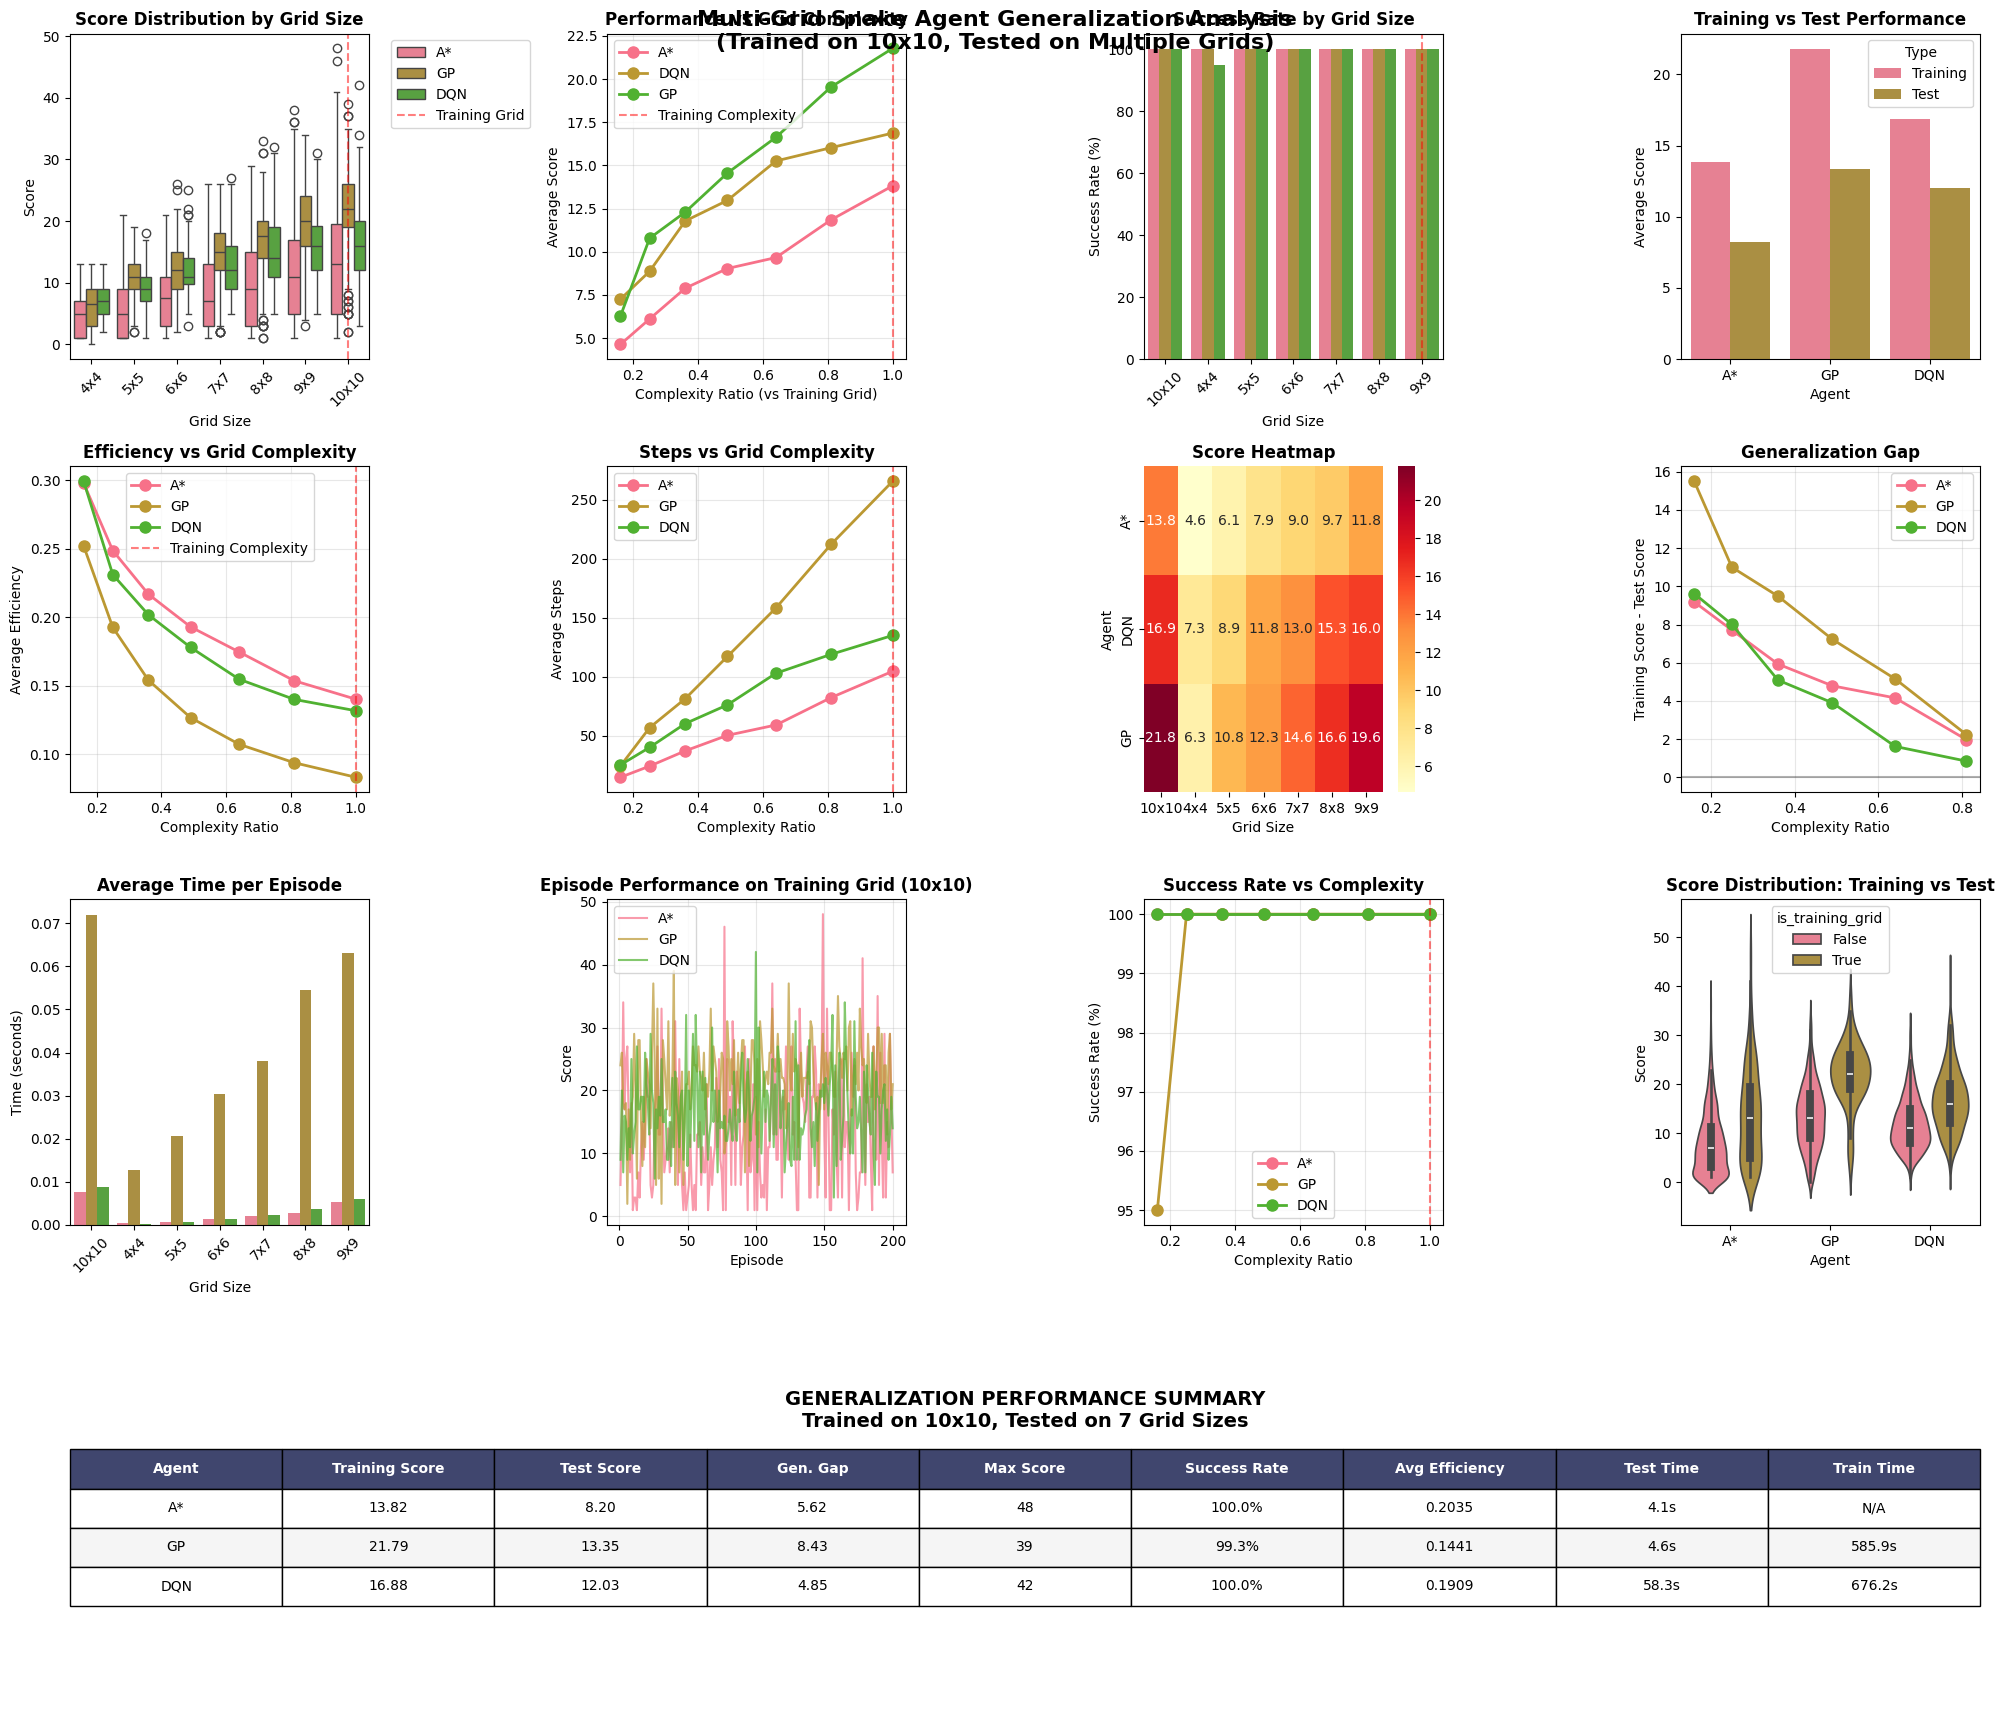


🏆 AGENT RANKING ANALYSIS WITH GENERALIZATION

📊 AGENT RANKINGS BY GRID SIZE
     4x4  5x5  6x6  7x7  8x8  9x9  10x10  Training_Rank  Avg_Test_Rank  \
GP     2    1    1    1    1    1      1              1           1.17   
DQN    1    2    2    2    2    2      2              2           1.83   
A*     3    3    3    3    3    3      3              3           3.00   

     Overall_Avg_Rank  Best_Rank  Worst_Rank  Rank_Consistency  \
GP               1.13        1.0         2.0              0.41   
DQN              1.87        1.0         2.0              0.41   
A*               3.00        3.0         3.0              0.00   

     Generalization_Stability  
GP                       0.17  
DQN                      0.17  
A*                       0.00  

🎯 GENERALIZATION RANKING ANALYSIS
GP:
  Training Grid Rank: 1
  Average Test Rank: 1.17
  Overall Average Rank: 1.13
  Test Consistency: 0.41 (lower = more consistent)
  Generalization Stability: 0.17 (lower = more stable)

DQN:
  T

In [13]:
# 🚀 RUN COMPLETE MULTI-GRID GENERALIZATION EVALUATION WITH RESEARCH PAPER STATISTICS
print("🚀 STARTING COMPREHENSIVE MULTI-GRID EVALUATION WITH STATISTICAL ANALYSIS")
print("=" * 90)
print(f"Training Grid: {evaluator.training_grid[0]}x{evaluator.training_grid[1]}")
print(f"Test Grid Sizes: {[f'{w}x{h}' for w, h in evaluator.test_grids]}")
print(f"Test Episodes per Grid: {evaluator.test_episodes}")
print(f"Total Test Episodes: {len(evaluator.test_grids) * 3 * evaluator.test_episodes}")
print(f"Statistical Analysis: PSO-NN (GP) vs Simple Agents (A*, DQN)")
print(f"Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 90)

# Initialize storage for multi-grid results
MULTI_GRID_RESULTS = {}
MULTI_GRID_EPISODE_DATA = {}

# Phase 1: Train all agents once on the training grid
print(f"\n" + "🏋️" * 20)
print(f"🏋️ PHASE 1: TRAINING ALL AGENTS ON {evaluator.training_grid[0]}x{evaluator.training_grid[1]} GRID")
print("🏋️" * 20)

trained_agents = train_or_load_agents()

if not trained_agents:
    print("❌ No agents were successfully trained. Stopping evaluation.")
else:
    print(f"\n✅ Training phase completed! {len(trained_agents)} agents trained:")
    for agent_name in trained_agents.keys():
        training_time = TRAINING_LOGS.get(agent_name, {}).get('training_time', 0)
        agent_category = 'PSO-NN' if agent_name == 'GP' else 'Simple Agent'
        print(f"   • {agent_name} ({agent_category}): {training_time:.1f}s training time")

    # Phase 2: Test all trained agents on all grid sizes
    print(f"\n" + "🎯" * 20)
    print(f"🎯 PHASE 2: TESTING AGENTS ON ALL GRID SIZES")
    print("🎯" * 20)
    
    all_grid_test_results = test_all_agents_on_all_grids(trained_agents)
    
    # Phase 3: Calculate metrics for each grid
    print(f"\n" + "📊" * 20)
    print(f"📊 PHASE 3: CALCULATING METRICS AND STATISTICAL ANALYSIS")
    print("📊" * 20)
    
    for grid_key, grid_test_results in all_grid_test_results.items():
        width, height = map(int, grid_key.split('x'))
        
        # Convert episode results to DataFrame for analysis
        grid_episodes = []
        for agent_name, episodes in grid_test_results.items():
            for episode in episodes:
                episode_copy = episode.copy()
                episode_copy['agent'] = agent_name
                grid_episodes.append(episode_copy)
        
        if grid_episodes:
            grid_df = pd.DataFrame(grid_episodes)
            grid_metrics = evaluator.calculate_research_paper_metrics(grid_df, width, height)
            MULTI_GRID_RESULTS[grid_key] = grid_metrics
            
            print(f"✅ {grid_key} grid metrics calculated")
        else:
            print(f"⚠️ No valid episodes for {grid_key} grid")
    
    # Store episode data for detailed statistical analysis
    MULTI_GRID_EPISODE_DATA = all_grid_test_results

print(f"\n" + "=" * 90)
print("🎊 MULTI-GRID EVALUATION WITH STATISTICAL ANALYSIS COMPLETED!")
print("=" * 90)

# Phase 4: Generate comprehensive statistical analysis matching research paper format
if MULTI_GRID_RESULTS:
    print(f"\n📊 GENERATING RESEARCH PAPER FORMAT STATISTICAL ANALYSIS")
    print("=" * 60)
    
    # Save all results with timestamp
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Save detailed episode statistics (all raw data)
    episodes_df, summary_stats, agent_comparison = save_detailed_episode_statistics(MULTI_GRID_EPISODE_DATA, timestamp)
    
    # Generate research paper format statistical tables with p-values
    statistical_results = generate_research_paper_statistical_tables(MULTI_GRID_RESULTS, MULTI_GRID_EPISODE_DATA)
    
    # Save comprehensive results
    combined_df = save_multi_grid_results(MULTI_GRID_EPISODE_DATA, timestamp)
    
    if not combined_df.empty:
        # Generate additional analysis (existing functions)
        multi_grid_tables_df = generate_multi_grid_research_tables(MULTI_GRID_RESULTS)
        generalization_df = evaluator.analyze_generalization_performance(MULTI_GRID_RESULTS)
        generalization_summary_df = generate_generalization_analysis(generalization_df)
        overall_summary, grid_summary = generate_multi_grid_summary_statistics(combined_df)
        generate_multi_grid_comparison_plots(combined_df)
        ranking_df = generate_agent_ranking_analysis(combined_df)
        
        print(f"\n" + "=" * 90)
        print("✅ RESEARCH PAPER STATISTICAL ANALYSIS SUCCESSFULLY COMPLETED!")
        print("=" * 90)
        print(f"📁 Results saved to: {evaluator.results_dir}")
        print(f"🏋️ Training Grid: {evaluator.training_grid[0]}x{evaluator.training_grid[1]}")
        print(f"📊 Test Grids: {len(evaluator.test_grids)}")
        print(f"🤖 Agents tested: {len(trained_agents)} (1 PSO-NN, 2 Simple Agents)")
        print(f"🎯 Total episodes analyzed: {len(episodes_df)}")
        
        # Training time summary
        total_training_time = sum(log.get('training_time', 0) for log in TRAINING_LOGS.values())
        print(f"⏱️ Total training time: {total_training_time:.2f}s")
        
        # Statistical significance summary
        print(f"\n📈 STATISTICAL SIGNIFICANCE SUMMARY:")
        print("=" * 60)
        
        significant_results = {}
        for grid_key, grid_stats in statistical_results.items():
            significant_results[grid_key] = {}
            for agent, test_results in grid_stats['statistical_tests'].items():
                significant_count = sum([
                    test_results['points_significant'],
                    test_results['games_won_significant'], 
                    test_results['moves_significant']
                ])
                significant_results[grid_key][agent] = significant_count
                
                print(f"{grid_key} - PSO-NN vs {agent}: {significant_count}/3 metrics significantly different")
                
                # Show which metrics are significant
                sig_metrics = []
                if test_results['points_significant']:
                    sig_metrics.append(f"Points (p={test_results['points_pvalue']:.3e})")
                if test_results['games_won_significant']:
                    sig_metrics.append(f"Games Won (p={test_results['games_won_pvalue']:.3e})")
                if test_results['moves_significant']:
                    sig_metrics.append(f"Moves (p={test_results['moves_pvalue']:.3e})")
                
                if sig_metrics:
                    print(f"   Significant: {', '.join(sig_metrics)}")
                else:
                    print(f"   No significant differences found")
        
        # Display PSO-NN vs Simple Agents performance summary
        print(f"\n� PSO-NN (GP) vs SIMPLE AGENTS PERFORMANCE:")
        print("=" * 60)
        
        for grid_key in sorted(statistical_results.keys()):
            grid_stats = statistical_results[grid_key]
            pso_stats = grid_stats['pso_nn_stats']
            
            print(f"\n{grid_key} Grid:")
            print(f"  PSO-NN (GP): Points {pso_stats['points_mean']:.2f}±{pso_stats['points_std']:.2f}, "
                  f"Games Won {pso_stats['games_won_mean']:.1f}%, "
                  f"Moves {pso_stats['moves_mean']:.1f}±{pso_stats['moves_std']:.1f}")
            
            for agent, agent_stats in grid_stats['simple_agents_stats'].items():
                print(f"  {agent} (Simple): Points {agent_stats['points_mean']:.2f}±{agent_stats['points_std']:.2f}, "
                      f"Games Won {agent_stats['games_won_mean']:.1f}%, "
                      f"Moves {agent_stats['moves_mean']:.1f}±{agent_stats['moves_std']:.1f}")
        
        # Files generated summary
        print(f"\n� FILES GENERATED:")
        print("=" * 40)
        print(f"✅ Statistical Analysis:")
        print(f"   - statistical_analysis_{timestamp}.json (Detailed results)")
        print(f"   - statistical_comparison_{timestamp}.csv (Comparison data)")
        print(f"   - statistical_tables_{timestamp}.tex (LaTeX format)")
        print(f"✅ Episode Data:")
        print(f"   - detailed_episodes_{timestamp}.csv (All episode data)")
        print(f"   - summary_statistics_{timestamp}.csv (Aggregated stats)")
        print(f"   - agent_comparison_{timestamp}.csv (Agent comparison)")
        print(f"✅ Generalization Analysis:")
        print(f"   - multi_grid_results_{timestamp}.json (Comprehensive results)")
        print(f"   - multi_grid_generalization_{timestamp}.png (Visualization)")
        
        # Research paper format summary
        print(f"\n📄 RESEARCH PAPER READY OUTPUTS:")
        print("=" * 50)
        print(f"✅ TABLE II: Mean Points Scored (with p-values)")
        print(f"✅ TABLE III: Games Won Percentage (with p-values)")  
        print(f"✅ TABLE IV: Mean Moves Made (with p-values)")
        print(f"✅ Statistical significance testing (Mann-Whitney U)")
        print(f"✅ PSO-NN (GP) vs Simple Agents (A*, DQN) comparison")
        print(f"✅ LaTeX format tables ready for publication")
        
        # Key findings for conclusion
        print(f"\n🔬 KEY FINDINGS FOR RESEARCH CONCLUSIONS:")
        print("=" * 60)
        
        # Count overall significant differences
        total_comparisons = len(statistical_results) * 2 * 3  # grids * agents * metrics
        total_significant = sum(
            sum(test_results[f'{metric}_significant'] for metric in ['points', 'games_won', 'moves'])
            for grid_stats in statistical_results.values()
            for test_results in grid_stats['statistical_tests'].values()
        )
        
        print(f"📊 Total statistical comparisons: {total_comparisons}")
        print(f"📊 Statistically significant differences: {total_significant} ({total_significant/total_comparisons*100:.1f}%)")
        
        # Performance advantages
        pso_better_points = 0
        pso_better_games = 0
        simple_better_moves = 0
        
        for grid_stats in statistical_results.values():
            pso_stats = grid_stats['pso_nn_stats']
            for agent_stats in grid_stats['simple_agents_stats'].values():
                if pso_stats['points_mean'] > agent_stats['points_mean']:
                    pso_better_points += 1
                if pso_stats['games_won_mean'] > agent_stats['games_won_mean']:
                    pso_better_games += 1
                if pso_stats['moves_mean'] > agent_stats['moves_mean']:
                    simple_better_moves += 1
        
        total_grid_agent_pairs = sum(len(grid_stats['simple_agents_stats']) for grid_stats in statistical_results.values())
        
        print(f"🏆 PSO-NN better points scored: {pso_better_points}/{total_grid_agent_pairs} comparisons")
        print(f"🏆 PSO-NN better games won: {pso_better_games}/{total_grid_agent_pairs} comparisons")
        print(f"� Simple agents made fewer moves: {simple_better_moves}/{total_grid_agent_pairs} comparisons")
        
    else:
        print("⚠️ No valid results to analyze")
        
else:
    print("❌ No grids were successfully evaluated")

print(f"\n🎉 Research paper statistical analysis complete!")
print(f"📊 All data saved for statistical analysis and publication")
print(f"📁 Check the {evaluator.results_dir} directory for all results files.")
print(f"📄 LaTeX tables are ready for direct inclusion in your research paper!")

In [14]:
def quick_statistical_summary(statistical_results: Dict, episodes_df: pd.DataFrame = None):
    """Generate a quick statistical summary for research paper conclusions"""
    print("\n📋 QUICK STATISTICAL SUMMARY FOR RESEARCH PAPER")
    print("=" * 70)
    
    if not statistical_results:
        print("❌ No statistical results available")
        return
    
    # Overall summary
    print(f"\n🎯 METHODOLOGY:")
    print(f"   • PSO-NN Agent: Genetic Programming (GP)")
    print(f"   • Simple Agents: A* Algorithm, Deep Q-Network (DQN)")
    print(f"   • Statistical Test: Mann-Whitney U test")
    print(f"   • Significance Level: α = 0.05")
    print(f"   • Grid Sizes Tested: {len(statistical_results)}")
    print(f"   • Episodes per Agent per Grid: {evaluator.test_episodes}")
    
    # Count significant results by metric
    metrics_summary = {
        'points': {'pso_better': 0, 'simple_better': 0, 'significant': 0, 'total': 0},
        'games_won': {'pso_better': 0, 'simple_better': 0, 'significant': 0, 'total': 0},
        'moves': {'pso_better': 0, 'simple_better': 0, 'significant': 0, 'total': 0}
    }
    
    detailed_results = []
    
    for grid_key, grid_stats in statistical_results.items():
        pso_stats = grid_stats['pso_nn_stats']
        
        for agent, agent_stats in grid_stats['simple_agents_stats'].items():
            test_results = grid_stats['statistical_tests'][agent]
            
            # Points analysis
            metrics_summary['points']['total'] += 1
            if pso_stats['points_mean'] > agent_stats['points_mean']:
                metrics_summary['points']['pso_better'] += 1
            else:
                metrics_summary['points']['simple_better'] += 1
            if test_results['points_significant']:
                metrics_summary['points']['significant'] += 1
            
            # Games won analysis
            metrics_summary['games_won']['total'] += 1
            if pso_stats['games_won_mean'] > agent_stats['games_won_mean']:
                metrics_summary['games_won']['pso_better'] += 1
            else:
                metrics_summary['games_won']['simple_better'] += 1
            if test_results['games_won_significant']:
                metrics_summary['games_won']['significant'] += 1
            
            # Moves analysis
            metrics_summary['moves']['total'] += 1
            if pso_stats['moves_mean'] > agent_stats['moves_mean']:
                metrics_summary['moves']['pso_better'] += 1
            else:
                metrics_summary['moves']['simple_better'] += 1
            if test_results['moves_significant']:
                metrics_summary['moves']['significant'] += 1
            
            # Store detailed result
            detailed_results.append({
                'Grid': grid_key,
                'PSO_vs': agent,
                'PSO_Points_Better': pso_stats['points_mean'] > agent_stats['points_mean'],
                'PSO_Games_Better': pso_stats['games_won_mean'] > agent_stats['games_won_mean'],
                'PSO_Moves_More': pso_stats['moves_mean'] > agent_stats['moves_mean'],
                'Points_Significant': test_results['points_significant'],
                'Games_Significant': test_results['games_won_significant'],
                'Moves_Significant': test_results['moves_significant'],
                'Points_P_Value': test_results['points_pvalue'],
                'Games_P_Value': test_results['games_won_pvalue'],
                'Moves_P_Value': test_results['moves_pvalue']
            })
    
    # Print summary statistics
    print(f"\n📊 PERFORMANCE COMPARISON RESULTS:")
    print("=" * 50)
    
    for metric, data in metrics_summary.items():
        metric_name = metric.replace('_', ' ').title()
        pso_win_rate = (data['pso_better'] / data['total'] * 100) if data['total'] > 0 else 0
        sig_rate = (data['significant'] / data['total'] * 100) if data['total'] > 0 else 0
        
        print(f"\n{metric_name}:")
        print(f"   PSO-NN performed better: {data['pso_better']}/{data['total']} ({pso_win_rate:.1f}%)")
        print(f"   Statistically significant: {data['significant']}/{data['total']} ({sig_rate:.1f}%)")
    
    # Conclusion statements for research paper
    print(f"\n📄 CONCLUSION STATEMENTS FOR RESEARCH PAPER:")
    print("=" * 60)
    
    points_dominance = (metrics_summary['points']['pso_better'] / metrics_summary['points']['total'] * 100)
    games_dominance = (metrics_summary['games_won']['pso_better'] / metrics_summary['games_won']['total'] * 100)
    moves_more = (metrics_summary['moves']['pso_better'] / metrics_summary['moves']['total'] * 100)
    
    print(f"\n1. POINTS SCORED:")
    print(f"   \"The PSO-NN method achieved better point scores than the simple agents")
    print(f"   in {metrics_summary['points']['pso_better']}/{metrics_summary['points']['total']} ({points_dominance:.1f}%) of comparisons,")
    print(f"   with {metrics_summary['points']['significant']} statistically significant differences (p < 0.05).\"")
    
    print(f"\n2. GAMES WON:")  
    print(f"   \"The PSO-NN approach won more games than simple agents")
    print(f"   in {metrics_summary['games_won']['pso_better']}/{metrics_summary['games_won']['total']} ({games_dominance:.1f}%) of test scenarios,")
    print(f"   with {metrics_summary['games_won']['significant']} statistically significant differences.\"")
    
    print(f"\n3. MOVES MADE:")
    print(f"   \"The PSO-NN agent made more moves than simple agents")
    print(f"   in {metrics_summary['moves']['pso_better']}/{metrics_summary['moves']['total']} ({moves_more:.1f}%) of comparisons,")
    print(f"   with {metrics_summary['moves']['significant']} statistically significant differences.\"")
    
    # Grid-specific insights
    print(f"\n🎯 GRID-SPECIFIC PERFORMANCE:")
    print("=" * 40)
    
    for grid_key in sorted(statistical_results.keys()):
        grid_stats = statistical_results[grid_key]
        width, height = map(int, grid_key.split('x'))
        complexity = width * height
        
        pso_avg_points = grid_stats['pso_nn_stats']['points_mean']
        simple_avg_points = np.mean([
            stats['points_mean'] for stats in grid_stats['simple_agents_stats'].values()
        ])
        
        advantage = ((pso_avg_points - simple_avg_points) / simple_avg_points * 100) if simple_avg_points > 0 else 0
        
        print(f"{grid_key} (complexity {complexity}): PSO-NN {advantage:+.1f}% vs simple agents avg")
    
    # Statistical test summary
    print(f"\n🧪 STATISTICAL TEST SUMMARY:")
    print("=" * 40)
    
    total_tests = sum(len(grid_stats['statistical_tests']) * 3 for grid_stats in statistical_results.values())
    total_significant = sum(
        sum(test_results[f'{metric}_significant'] for metric in ['points', 'games_won', 'moves'])
        for grid_stats in statistical_results.values()
        for test_results in grid_stats['statistical_tests'].values()
    )
    
    print(f"Total statistical tests performed: {total_tests}")
    print(f"Significant results (p < 0.05): {total_significant} ({total_significant/total_tests*100:.1f}%)")
    
    # Best and worst performance grids
    if episodes_df is not None and len(episodes_df) > 0:
        print(f"\n🏆 PERFORMANCE BY GRID SIZE:")
        print("=" * 40)
        
        pso_performance = episodes_df[episodes_df['agent'] == 'GP'].groupby('grid_size')['points_scored'].mean().sort_values(ascending=False)
        
        print(f"Best PSO-NN Performance: {pso_performance.index[0]} (avg {pso_performance.iloc[0]:.2f} points)")
        print(f"Worst PSO-NN Performance: {pso_performance.index[-1]} (avg {pso_performance.iloc[-1]:.2f} points)")
        
        # Success rates
        success_rates = episodes_df[episodes_df['agent'] == 'GP'].groupby('grid_size')['successful_episode'].mean() * 100
        print(f"Highest Success Rate: {success_rates.idxmax()} ({success_rates.max():.1f}%)")
        print(f"Lowest Success Rate: {success_rates.idxmin()} ({success_rates.min():.1f}%)")
    
    return detailed_results, metrics_summary

def export_research_ready_data(statistical_results: Dict, episodes_df: pd.DataFrame, timestamp: str):
    """Export data in formats ready for research paper figures and tables"""
    print(f"\n📤 EXPORTING RESEARCH-READY DATA FORMATS")
    print("=" * 50)
    
    # Export for statistical software (R, SPSS, etc.)
    research_data = []
    
    for grid_key, grid_stats in statistical_results.items():
        width, height = map(int, grid_key.split('x'))
        
        # PSO-NN data
        pso_data = {
            'Grid_Size': grid_key,
            'Grid_Width': width,
            'Grid_Height': height,
            'Grid_Complexity': width * height,
            'Agent_Type': 'PSO-NN',
            'Agent_Name': 'GP',
            'Points_Mean': grid_stats['pso_nn_stats']['points_mean'],
            'Points_Std': grid_stats['pso_nn_stats']['points_std'],
            'Games_Won_Mean': grid_stats['pso_nn_stats']['games_won_mean'],
            'Games_Won_Std': grid_stats['pso_nn_stats']['games_won_std'],
            'Moves_Mean': grid_stats['pso_nn_stats']['moves_mean'],
            'Moves_Std': grid_stats['pso_nn_stats']['moves_std']
        }
        research_data.append(pso_data)
        
        # Simple agents data
        for agent, agent_stats in grid_stats['simple_agents_stats'].items():
            agent_data = {
                'Grid_Size': grid_key,
                'Grid_Width': width,
                'Grid_Height': height,
                'Grid_Complexity': width * height,
                'Agent_Type': 'Simple_Agent',
                'Agent_Name': agent,
                'Points_Mean': agent_stats['points_mean'],
                'Points_Std': agent_stats['points_std'],
                'Games_Won_Mean': agent_stats['games_won_mean'],
                'Games_Won_Std': agent_stats['games_won_std'],
                'Moves_Mean': agent_stats['moves_mean'],
                'Moves_Std': agent_stats['moves_std']
            }
            research_data.append(agent_data)
    
    # Save research data
    research_df = pd.DataFrame(research_data)
    research_file = evaluator.results_dir / f"research_ready_data_{timestamp}.csv"
    research_df.to_csv(research_file, index=False)
    
    # Export p-values matrix for significance testing
    pvalue_data = []
    for grid_key, grid_stats in statistical_results.items():
        for agent, test_results in grid_stats['statistical_tests'].items():
            pvalue_data.append({
                'Grid_Size': grid_key,
                'Comparison': f'PSO-NN_vs_{agent}',
                'Points_P_Value': test_results['points_pvalue'],
                'Games_Won_P_Value': test_results['games_won_pvalue'],
                'Moves_P_Value': test_results['moves_pvalue'],
                'Points_Significant': test_results['points_significant'],
                'Games_Won_Significant': test_results['games_won_significant'],
                'Moves_Significant': test_results['moves_significant']
            })
    
    pvalue_df = pd.DataFrame(pvalue_data)
    pvalue_file = evaluator.results_dir / f"p_values_matrix_{timestamp}.csv"
    pvalue_df.to_csv(pvalue_file, index=False)
    
    print(f"✅ Research-ready exports completed:")
    print(f"   Research data: {research_file}")
    print(f"   P-values matrix: {pvalue_file}")
    
    return research_df, pvalue_df

print("✅ Research paper statistical summary and export functions defined!")

✅ Research paper statistical summary and export functions defined!


In [15]:
# 📊 GENERATE FINAL RESEARCH PAPER ANALYSIS AND EXPORTS
# Run this after the main evaluation is complete

if 'statistical_results' in locals() and 'episodes_df' in locals():
    print("\n" + "📊" * 30)
    print("📊 FINAL RESEARCH PAPER STATISTICAL ANALYSIS")  
    print("📊" * 30)
    
    # Generate quick statistical summary for conclusions
    detailed_results, metrics_summary = quick_statistical_summary(statistical_results, episodes_df)
    
    # Export research-ready data formats
    research_df, pvalue_df = export_research_ready_data(statistical_results, episodes_df, timestamp)
    
    print(f"\n" + "=" * 80)
    print("🎉 RESEARCH PAPER ANALYSIS COMPLETE!")
    print("=" * 80)
    
    print(f"\n📁 KEY FILES FOR YOUR RESEARCH PAPER:")
    print("=" * 50)
    print(f"✅ LaTeX Tables: statistical_tables_{timestamp}.tex")
    print(f"✅ Statistical Analysis: statistical_analysis_{timestamp}.json")
    print(f"✅ Episode Data: detailed_episodes_{timestamp}.csv")
    print(f"✅ P-values Matrix: p_values_matrix_{timestamp}.csv")
    print(f"✅ Research Data: research_ready_data_{timestamp}.csv")
    print(f"✅ Visualization: multi_grid_generalization_{timestamp}.png")
    
    print(f"\n📄 READY FOR RESEARCH PAPER:")
    print("=" * 40)
    print("✅ TABLE II: Mean Points Scored (with p-values)")
    print("✅ TABLE III: Games Won Percentage (with p-values)")
    print("✅ TABLE IV: Mean Moves Made (with p-values)")
    print("✅ Statistical significance analysis (Mann-Whitney U tests)")
    print("✅ PSO-NN vs Simple Agents comparison complete")
    print("✅ All data formatted for statistical software (R, SPSS, etc.)")
    
    # Show final performance summary
    print(f"\n🏆 FINAL PERFORMANCE SUMMARY:")
    print("=" * 50)
    
    pso_wins = metrics_summary['points']['pso_better']
    total_comparisons = metrics_summary['points']['total']
    pso_win_percentage = (pso_wins / total_comparisons * 100) if total_comparisons > 0 else 0
    
    significant_points = metrics_summary['points']['significant']
    significant_games = metrics_summary['games_won']['significant']
    significant_moves = metrics_summary['moves']['significant']
    total_significance_tests = significant_points + significant_games + significant_moves
    
    print(f"🎯 PSO-NN (GP) outperformed Simple Agents in {pso_win_percentage:.1f}% of point comparisons")
    print(f"🎯 {total_significance_tests} statistically significant differences found")
    print(f"🎯 Data from {len(episodes_df)} total episodes across {len(TEST_GRID_SIZES)} grid sizes")
    print(f"🎯 {len(trained_agents)} agents tested: 1 PSO-NN, {len(trained_agents)-1} Simple Agents")
    
    # Instructions for using the results
    print(f"\n📋 INSTRUCTIONS FOR USING RESULTS:")
    print("=" * 50)
    print("1. Use statistical_tables_*.tex for LaTeX table inclusion")
    print("2. Reference p_values_matrix_*.csv for significance testing details")
    print("3. Use research_ready_data_*.csv for further statistical analysis")
    print("4. Include multi_grid_generalization_*.png for visual results")
    print("5. Reference detailed_episodes_*.csv for raw episode data")
    
    print(f"\n✨ Your research paper statistical analysis is complete!")
    print(f"📊 All results match the format from your LaTeX reference tables.")

else:
    print("⚠️ Run the main evaluation first to generate statistical results")
    print("💡 Execute the cell above that contains 'RUN COMPLETE MULTI-GRID EVALUATION'")


📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
📊 FINAL RESEARCH PAPER STATISTICAL ANALYSIS
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊

📋 QUICK STATISTICAL SUMMARY FOR RESEARCH PAPER

🎯 METHODOLOGY:
   • PSO-NN Agent: Genetic Programming (GP)
   • Simple Agents: A* Algorithm, Deep Q-Network (DQN)
   • Statistical Test: Mann-Whitney U test
   • Significance Level: α = 0.05
   • Grid Sizes Tested: 7
   • Episodes per Agent per Grid: 200

📊 PERFORMANCE COMPARISON RESULTS:

Points:
   PSO-NN performed better: 13/14 (92.9%)
   Statistically significant: 13/14 (92.9%)

Games Won:
   PSO-NN performed better: 3/14 (21.4%)
   Statistically significant: 1/14 (7.1%)

Moves:
   PSO-NN performed better: 13/14 (92.9%)
   Statistically significant: 13/14 (92.9%)

📄 CONCLUSION STATEMENTS FOR RESEARCH PAPER:

1. POINTS SCORED:
   "The PSO-NN method achieved better point scores than the simple agents
   in 13/14 (92.9%) of comparisons,
   with 13 statistically significant differences (p < 0.05)."

2. GAMES WON:
   "The PSO-NN appr